By:  David R. Torres<br>
Flatiron School<br>
Github repo: https://github.com/davidrtorres/dsc-mod-4-project-v2-1-onl01-dtsc-pt-041320/tree/master

# **Using an ARIMA Model for Time Series Forecasting**

### **Introduction**
Business Problem: I am a consultant for Premium Real Estate, LLC.  The firm asked me to provide analysis and recommendations for investing in real estate in the top 5 zipcodes in Brooklyn, NY that will provide the highest return on investment.  The investment firm is looking for short-term investments with the highest returns over a 3 year period.  The investment firm isn't looking for long term investments.<br>
<br>
I will make recommendations based on the real estate prices in Brooklyn. The top 5 zipcodes or 'best' zipcodes will be those with the highest ROI over the 3 year period.<br>
<br>
For the task, I analyzed real estate sales data from Zillow which covers the time period 4-1-1996 to 4-1-2018.<br>
I used an Auto Arima model to conduct a gridsearch and find the p,d,qs and Seasonal P,D,Qs with the lowest related AIC scores for each zipcode.  I used a SARIMA model to make predictions regarding the test data.  I used the metric RMSE to evaluate how my models were performing in making predictons.  I then made models to perform dynamic forecasts for 3 years.<br>

In [1]:
print('Notebook 12-18-20')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.tsa.stattools import adfuller

import warnings
warnings.filterwarnings('ignore')
import itertools
import statsmodels.api as sm

Notebook 12-18-20


In [2]:
zillow = pd.read_csv('https://raw.githubusercontent.com/learn-co-students/dsc-mod-4-project-v2-1-onl01-dtsc-ft-070620/master/time-series/zillow_data.csv')

In [3]:
zillow.rename(columns={'RegionName': 'Zipcode'}, inplace=True)
zillow.head()

,RegionID,Zipcode,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


## Preprocessing Data
### Melted Data Function
The dataset is from Zillow.com so I had to first reshape the data frame from wide to long format using the function .melt() and then transform it into a time series data frame.  Then I created a subset of the dataframe for only properties located under column 'State' of 'NY' and column 'CountyName' of 'Kings'.   

In [4]:
def melt_data(df):
    """
    df - is the dataframe
    This is a time series so I need a column for dates to become the index.
    .melt() function sets up dataframe so date columns can be merged as a single column.  
    """
    melted = pd.melt(df, id_vars=['RegionID','Zipcode', 'City', 'State', 'Metro', 'CountyName', 
                                  'SizeRank'], var_name='Month', value_name='MeanValue')
    melted['Month'] = pd.to_datetime(melted['Month'], format='%Y-%m')
    #melted = melted.set_index('Month')
    melted = melted.dropna(subset=['MeanValue'])
    return melted

In [5]:
all_zipcodes = melt_data(zillow)

In [6]:
all_zipcodes.columns

Index(['RegionID', 'Zipcode', 'City', 'State', 'Metro', 'CountyName',
       'SizeRank', 'Month', 'MeanValue'],
      dtype='object')

In [7]:
all_zipcodes.head(10)

,RegionID,Zipcode,City,State,Metro,CountyName,SizeRank,Month,MeanValue
0,84654,60657,Chicago,IL,Chicago,Cook,1,1996-04-01,334200.0
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,1996-04-01,235700.0
2,91982,77494,Katy,TX,Houston,Harris,3,1996-04-01,210400.0
3,84616,60614,Chicago,IL,Chicago,Cook,4,1996-04-01,498100.0
4,93144,79936,El Paso,TX,El Paso,El Paso,5,1996-04-01,77300.0
5,91733,77084,Houston,TX,Houston,Harris,6,1996-04-01,95000.0
6,61807,10467,New York,NY,New York,Bronx,7,1996-04-01,152900.0
7,84640,60640,Chicago,IL,Chicago,Cook,8,1996-04-01,216500.0
8,91940,77449,Katy,TX,Houston,Harris,9,1996-04-01,95400.0
9,97564,94109,San Francisco,CA,San Francisco,San Francisco,10,1996-04-01,766000.0


In [8]:
kings_zips = all_zipcodes[(all_zipcodes['CountyName']=='Kings') & (all_zipcodes['State']== 'NY')]
kings_zips

,RegionID,Zipcode,City,State,Metro,CountyName,SizeRank,Month,MeanValue
10,62037,11226,New York,NY,New York,Kings,11,1996-04-01,162000.0
13,62045,11235,New York,NY,New York,Kings,14,1996-04-01,190500.0
47,62040,11230,New York,NY,New York,Kings,48,1996-04-01,230100.0
49,62020,11209,New York,NY,New York,Kings,50,1996-04-01,255700.0
53,62023,11212,New York,NY,New York,Kings,54,1996-04-01,125000.0
...,...,...,...,...,...,...,...,...,...
3887683,62035,11224,New York,NY,New York,Kings,812,2018-04-01,517900.0
3888027,62033,11222,New York,NY,New York,Kings,1156,2018-04-01,1721100.0
3888306,62016,11205,New York,NY,New York,Kings,1435,2018-04-01,2248400.0
3888406,62028,11217,New York,NY,New York,Kings,1535,2018-04-01,3656000.0


In [9]:
#for loop gets the monthly mean sales price for each Brooklyn zipcode and puts it in dictionary. 

test_dict = {}

for zipcode in kings_zips['Zipcode'].unique(): 
    all_zips = kings_zips[kings_zips['Zipcode'] == zipcode]
    all_zips = all_zips.set_index('Month')['MeanValue']
    all_zips = all_zips.asfreq('MS')
    all_zips.name = zipcode
    test_dict[zipcode] = all_zips
    

In [10]:
test_dict

{11226: Month
 1996-04-01    162000.0
 1996-05-01    162300.0
 1996-06-01    162600.0
 1996-07-01    163000.0
 1996-08-01    163400.0
                 ...   
 2017-12-01    887800.0
 2018-01-01    890500.0
 2018-02-01    901700.0
 2018-03-01    930700.0
 2018-04-01    963200.0
 Freq: MS, Name: 11226, Length: 265, dtype: float64,
 11235: Month
 1996-04-01    190500.0
 1996-05-01    191000.0
 1996-06-01    191500.0
 1996-07-01    192000.0
 1996-08-01    192500.0
                 ...   
 2017-12-01    799700.0
 2018-01-01    806600.0
 2018-02-01    810600.0
 2018-03-01    813400.0
 2018-04-01    816200.0
 Freq: MS, Name: 11235, Length: 265, dtype: float64,
 11230: Month
 1996-04-01     230100.0
 1996-05-01     230800.0
 1996-06-01     231500.0
 1996-07-01     232100.0
 1996-08-01     232800.0
                 ...    
 2017-12-01    1102400.0
 2018-01-01    1120200.0
 2018-02-01    1141600.0
 2018-03-01    1170000.0
 2018-04-01    1195400.0
 Freq: MS, Name: 11230, Length: 265, dtype: float

In [11]:
zip_df = pd.concat(test_dict, axis=1)

In [12]:
len(zip_df)

265

### **Dataframe of Brooklyn Zipcodes** 

After pre-processing the data I limited the scope of my search to real property in Brookyln, NY.  These
properties were identified in the dataframe under 'CountyName' as 'King'.

In [13]:
type(zip_df[11226])

pandas.core.series.Series

In [14]:
zip_df.head()

,11226,11235,11230,11209,11212,11214,11221,11229,11234,11215,...,11203,11220,11216,11210,11224,11222,11228,11238,11205,11217
Month,,,,,,,,,,,,,,,,,,,,,
1996-04-01,162000.0,190500.0,230100.0,255700.0,125000.0,191000.0,133700.0,183900.0,172300.0,225700.0,...,149000.0,188500.0,146100.0,187300.0,158000.0,149200.0,219300.0,NaN,NaN,NaN
1996-05-01,162300.0,191000.0,230800.0,256600.0,125000.0,191200.0,133700.0,184200.0,172100.0,227500.0,...,149200.0,188700.0,146600.0,187300.0,157300.0,148400.0,219600.0,NaN,NaN,NaN
1996-06-01,162600.0,191500.0,231500.0,257300.0,125000.0,191500.0,133700.0,184500.0,171900.0,229400.0,...,149400.0,188800.0,147200.0,187200.0,156700.0,147500.0,219900.0,NaN,NaN,NaN
1996-07-01,163000.0,192000.0,232100.0,258100.0,125000.0,191900.0,133700.0,184800.0,171600.0,231600.0,...,149600.0,189000.0,147700.0,187100.0,156100.0,146600.0,220200.0,NaN,NaN,NaN
1996-08-01,163400.0,192500.0,232800.0,258900.0,125100.0,192100.0,133900.0,185000.0,171400.0,234100.0,...,149700.0,189400.0,148400.0,187000.0,155600.0,146000.0,220600.0,NaN,NaN,NaN


In [15]:
zip_df.tail()

,11226,11235,11230,11209,11212,11214,11221,11229,11234,11215,...,11203,11220,11216,11210,11224,11222,11228,11238,11205,11217
Month,,,,,,,,,,,,,,,,,,,,,
2017-12-01,887800.0,799700.0,1102400.0,1018900.0,414900.0,826300.0,998100.0,741000.0,575000.0,2287100.0,...,474500.0,903000.0,1545700.0,802900.0,498700.0,1651200.0,902200.0,2768900.0,2251000.0,3404100.0
2018-01-01,890500.0,806600.0,1120200.0,1023500.0,422300.0,827600.0,1000900.0,748100.0,579400.0,2288900.0,...,475300.0,906500.0,1540200.0,809100.0,502000.0,1661800.0,909000.0,2810700.0,2251600.0,3413800.0
2018-02-01,901700.0,810600.0,1141600.0,1029200.0,426300.0,830500.0,1015400.0,755800.0,583200.0,2265300.0,...,474800.0,910700.0,1553600.0,814500.0,505600.0,1672800.0,912800.0,2848100.0,2245300.0,3482900.0
2018-03-01,930700.0,813400.0,1170000.0,1023000.0,427100.0,837300.0,1037300.0,766200.0,589400.0,2244900.0,...,481000.0,915600.0,1578400.0,816900.0,511600.0,1694000.0,913900.0,2869600.0,2243700.0,3588100.0
2018-04-01,963200.0,816200.0,1195400.0,1015800.0,428400.0,844100.0,1048700.0,775500.0,593300.0,2243900.0,...,489900.0,917900.0,1598700.0,819600.0,517900.0,1721100.0,915300.0,2885300.0,2248400.0,3656000.0


In [16]:
len(zip_df.columns)

28

In [17]:
zip_df.index

DatetimeIndex(['1996-04-01', '1996-05-01', '1996-06-01', '1996-07-01',
               '1996-08-01', '1996-09-01', '1996-10-01', '1996-11-01',
               '1996-12-01', '1997-01-01',
               ...
               '2017-07-01', '2017-08-01', '2017-09-01', '2017-10-01',
               '2017-11-01', '2017-12-01', '2018-01-01', '2018-02-01',
               '2018-03-01', '2018-04-01'],
              dtype='datetime64[ns]', name='Month', length=265, freq='MS')

In [18]:
zip_df.isna().sum()

11226     0
11235     0
11230     0
11209     0
11212     0
11214     0
11221     0
11229     0
11234     0
11215     0
11211     0
11233     0
11236     0
11218     0
11223     0
11208     0
11204     0
11219     0
11203     0
11220     0
11216     0
11210     0
11224     0
11222     0
11228     0
11238    93
11205    93
11217    93
dtype: int64

#### **NaN Values**

In [19]:
zip_df.bfill(inplace=True)

In [20]:
zip_df.isna().sum()

11226    0
11235    0
11230    0
11209    0
11212    0
11214    0
11221    0
11229    0
11234    0
11215    0
11211    0
11233    0
11236    0
11218    0
11223    0
11208    0
11204    0
11219    0
11203    0
11220    0
11216    0
11210    0
11224    0
11222    0
11228    0
11238    0
11205    0
11217    0
dtype: int64

In [21]:
zip_df[11238].value_counts(dropna=False)

671200.0     94
1177800.0     2
1839100.0     1
1033400.0     1
2530000.0     1
             ..
2346900.0     1
665400.0      1
1237600.0     1
1361500.0     1
1638400.0     1
Name: 11238, Length: 171, dtype: int64

In [22]:
zip_df.keys()

Int64Index([11226, 11235, 11230, 11209, 11212, 11214, 11221, 11229, 11234,
            11215, 11211, 11233, 11236, 11218, 11223, 11208, 11204, 11219,
            11203, 11220, 11216, 11210, 11224, 11222, 11228, 11238, 11205,
            11217],
           dtype='int64')

In [23]:
zip_df[11238].head()

Month
1996-04-01    671200.0
1996-05-01    671200.0
1996-06-01    671200.0
1996-07-01    671200.0
1996-08-01    671200.0
Freq: MS, Name: 11238, dtype: float64

### **Plot of Price Trends of Brooklyn Zipcodes**

This is a plot of the time series data for each zip code demonstrating the price trends.  There are 28 zipcodes.  An overall upward trend can be observed from the years 1996 to 2018.  Regarding the housing bubble, we can see in the plot that housing prices peaked in early 2006, started to decline in 2006 and 2007, and then reached lows in 2012.<br>
The top 5 zip codes have consistently been top 5 performers for around 14 years.  The bottom 3 zipcodes displayed little change in price over time compared to top priced zip codes.  

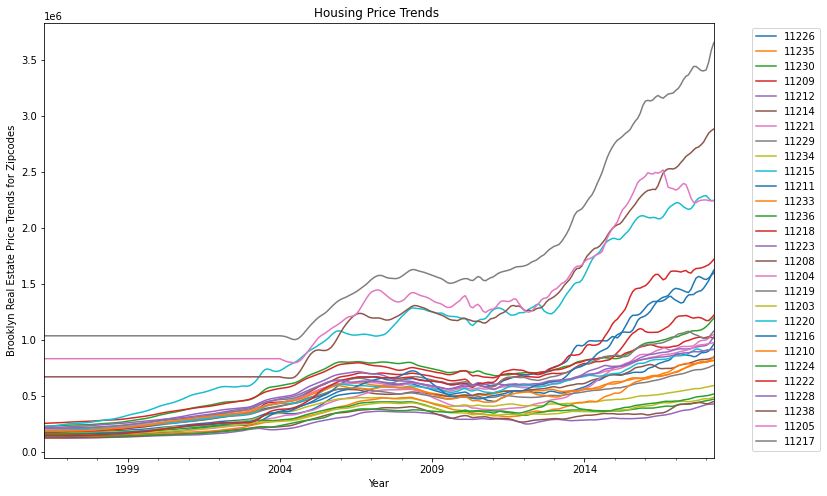

In [24]:
zip_df.plot(figsize=(12,8))
plt.title("Housing Price Trends ")
#plt.set(title=f'Housing Prices by Year - {zip_df.index.freq}')
plt.xlabel('Year')
plt.ylabel('Brooklyn Real Estate Price Trends for Zipcodes')
plt.legend(bbox_to_anchor=(1.05,1),loc='upper left')

#### Plot of top 6 zipcodes with highest sale prices over extended periods. 

In [25]:
zip_df_1 = zip_df[[11217, 11238,11215,11216,11222,11205]]

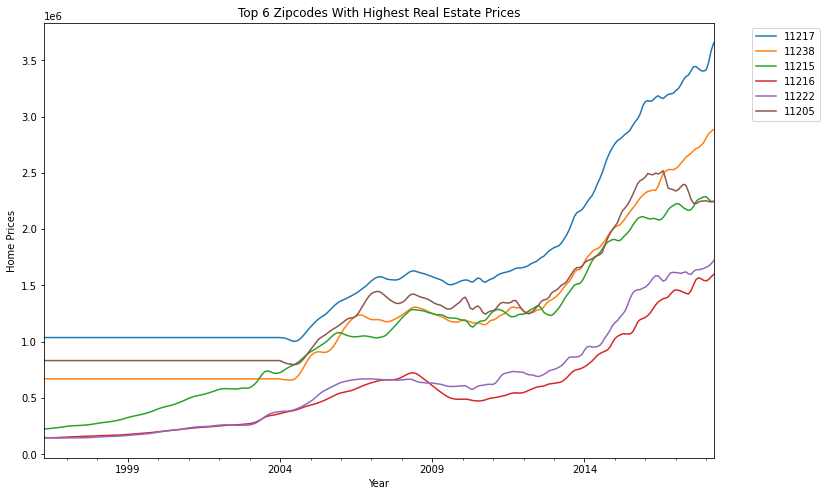

In [26]:
zip_df_1.plot(figsize=(12,8))
plt.title("Top 6 Zipcodes With Highest Real Estate Prices")
#plt.set(title=f'Housing Prices by Year - {zip_df.index.freq}')
plt.xlabel('Year')
plt.ylabel('Home Prices')
plt.legend(bbox_to_anchor=(1.05,1),loc='upper left')

Zipcodes: 11217, 11238, 11205 had the same values for monthly real easte so I created a plot eliminating these dates.  <br>

In [27]:
zip_no_nan = zip_df_1['2003-12-01':] 
zip_no_nan

,11217,11238,11215,11216,11222,11205
Month,,,,,,
2003-12-01,1037600.0,671200.0,720300.0,356700.0,378200.0,833100.0
2004-01-01,1037600.0,671200.0,727100.0,362600.0,380700.0,833100.0
2004-02-01,1035300.0,665400.0,739000.0,368600.0,382000.0,821400.0
2004-03-01,1031400.0,662500.0,754000.0,374200.0,383200.0,812000.0
2004-04-01,1024000.0,660200.0,768600.0,379000.0,384700.0,805500.0
...,...,...,...,...,...,...
2017-12-01,3404100.0,2768900.0,2287100.0,1545700.0,1651200.0,2251000.0
2018-01-01,3413800.0,2810700.0,2288900.0,1540200.0,1661800.0,2251600.0
2018-02-01,3482900.0,2848100.0,2265300.0,1553600.0,1672800.0,2245300.0


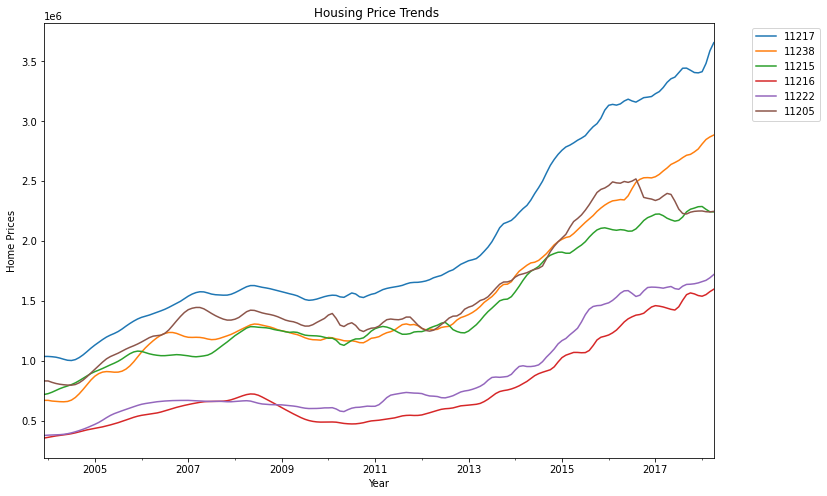

In [28]:
zip_no_nan.plot(figsize=(12,8))
plt.title("Housing Price Trends ")
#plt.set(title=f'Housing Prices by Year - {zip_df.index.freq}')
plt.xlabel('Year')
plt.ylabel('Home Prices')
plt.legend(bbox_to_anchor=(1.05,1),loc='upper left')

In [29]:
zip_df.tail()

,11226,11235,11230,11209,11212,11214,11221,11229,11234,11215,...,11203,11220,11216,11210,11224,11222,11228,11238,11205,11217
Month,,,,,,,,,,,,,,,,,,,,,
2017-12-01,887800.0,799700.0,1102400.0,1018900.0,414900.0,826300.0,998100.0,741000.0,575000.0,2287100.0,...,474500.0,903000.0,1545700.0,802900.0,498700.0,1651200.0,902200.0,2768900.0,2251000.0,3404100.0
2018-01-01,890500.0,806600.0,1120200.0,1023500.0,422300.0,827600.0,1000900.0,748100.0,579400.0,2288900.0,...,475300.0,906500.0,1540200.0,809100.0,502000.0,1661800.0,909000.0,2810700.0,2251600.0,3413800.0
2018-02-01,901700.0,810600.0,1141600.0,1029200.0,426300.0,830500.0,1015400.0,755800.0,583200.0,2265300.0,...,474800.0,910700.0,1553600.0,814500.0,505600.0,1672800.0,912800.0,2848100.0,2245300.0,3482900.0
2018-03-01,930700.0,813400.0,1170000.0,1023000.0,427100.0,837300.0,1037300.0,766200.0,589400.0,2244900.0,...,481000.0,915600.0,1578400.0,816900.0,511600.0,1694000.0,913900.0,2869600.0,2243700.0,3588100.0
2018-04-01,963200.0,816200.0,1195400.0,1015800.0,428400.0,844100.0,1048700.0,775500.0,593300.0,2243900.0,...,489900.0,917900.0,1598700.0,819600.0,517900.0,1721100.0,915300.0,2885300.0,2248400.0,3656000.0


### **Train/Test Split**
The zip_df dataset will be split into train and test sets to be used as inputs for the models.  Train data set is from 1996–04–01 to 2014–01–01. The length of our train data set is 214 rows, or 214 time periods.<br>
Test data set is from 2014–01–01 to 2018–04–01. The length of the test data is 52 rows, or 52 time periods. 
That is the value will use for our .predict() method. 

In [30]:
year = '2014-01-01'
train_brk = zip_df.loc[:year]
#test_brk = zip_df.loc[year:]
test_brk = zip_df.loc['2014-01-02':]

In [31]:
print(len(zip_df))
print(train_brk.shape)
print(test_brk.shape)

265
(214, 28)
(51, 28)


In [32]:
train_brk.tail()

,11226,11235,11230,11209,11212,11214,11221,11229,11234,11215,...,11203,11220,11216,11210,11224,11222,11228,11238,11205,11217
Month,,,,,,,,,,,,,,,,,,,,,
2013-09-01,551600.0,545200.0,791000.0,787900.0,280900.0,602000.0,530100.0,524200.0,437100.0,1501900.0,...,362700.0,657900.0,744700.0,544400.0,409800.0,863400.0,660800.0,1613500.0,1640100.0,2111700.0
2013-10-01,558900.0,547300.0,802300.0,796100.0,282200.0,607600.0,538200.0,527500.0,437800.0,1513200.0,...,362600.0,667100.0,752500.0,546500.0,397700.0,866600.0,667100.0,1638400.0,1658800.0,2146000.0
2013-11-01,566200.0,550600.0,809000.0,799700.0,282500.0,608800.0,545800.0,530400.0,437700.0,1516200.0,...,361700.0,669800.0,757800.0,549200.0,387300.0,870800.0,671500.0,1640700.0,1659500.0,2158600.0
2013-12-01,572600.0,554600.0,813000.0,806000.0,283300.0,608300.0,556100.0,533500.0,438900.0,1536500.0,...,361000.0,670500.0,766200.0,554300.0,382900.0,888300.0,677300.0,1661500.0,1670200.0,2173100.0
2014-01-01,580700.0,558200.0,819000.0,813900.0,285200.0,612200.0,569100.0,537700.0,441500.0,1577500.0,...,361000.0,674600.0,777900.0,561500.0,380800.0,924400.0,685900.0,1709200.0,1700200.0,2202400.0


In [33]:
test_brk.head()

,11226,11235,11230,11209,11212,11214,11221,11229,11234,11215,...,11203,11220,11216,11210,11224,11222,11228,11238,11205,11217
Month,,,,,,,,,,,,,,,,,,,,,
2014-02-01,590500.0,560000.0,822500.0,822200.0,286800.0,621100.0,577700.0,541600.0,444400.0,1623300.0,...,360700.0,680800.0,792400.0,565400.0,376900.0,954100.0,692700.0,1748800.0,1718500.0,2238400.0
2014-03-01,602600.0,562300.0,823200.0,827400.0,287000.0,632100.0,584600.0,545000.0,446100.0,1673000.0,...,359900.0,684500.0,810600.0,565800.0,372100.0,959900.0,695800.0,1773300.0,1727000.0,2271000.0
2014-04-01,618300.0,566300.0,824000.0,829200.0,286500.0,641600.0,600100.0,548300.0,446500.0,1716700.0,...,358600.0,683300.0,829200.0,564200.0,368400.0,953400.0,696900.0,1798700.0,1736700.0,2298000.0
2014-05-01,632300.0,572000.0,827900.0,830700.0,286400.0,647800.0,619900.0,550600.0,447700.0,1748300.0,...,358900.0,680800.0,852900.0,562100.0,367300.0,953400.0,700100.0,1818100.0,1752000.0,2342400.0
2014-06-01,638900.0,577500.0,833000.0,833900.0,288000.0,653000.0,639600.0,551200.0,449600.0,1767100.0,...,359200.0,677900.0,877300.0,561900.0,366300.0,957600.0,705200.0,1824000.0,1764200.0,2397200.0


In [34]:
test_brk.tail()

,11226,11235,11230,11209,11212,11214,11221,11229,11234,11215,...,11203,11220,11216,11210,11224,11222,11228,11238,11205,11217
Month,,,,,,,,,,,,,,,,,,,,,
2017-12-01,887800.0,799700.0,1102400.0,1018900.0,414900.0,826300.0,998100.0,741000.0,575000.0,2287100.0,...,474500.0,903000.0,1545700.0,802900.0,498700.0,1651200.0,902200.0,2768900.0,2251000.0,3404100.0
2018-01-01,890500.0,806600.0,1120200.0,1023500.0,422300.0,827600.0,1000900.0,748100.0,579400.0,2288900.0,...,475300.0,906500.0,1540200.0,809100.0,502000.0,1661800.0,909000.0,2810700.0,2251600.0,3413800.0
2018-02-01,901700.0,810600.0,1141600.0,1029200.0,426300.0,830500.0,1015400.0,755800.0,583200.0,2265300.0,...,474800.0,910700.0,1553600.0,814500.0,505600.0,1672800.0,912800.0,2848100.0,2245300.0,3482900.0
2018-03-01,930700.0,813400.0,1170000.0,1023000.0,427100.0,837300.0,1037300.0,766200.0,589400.0,2244900.0,...,481000.0,915600.0,1578400.0,816900.0,511600.0,1694000.0,913900.0,2869600.0,2243700.0,3588100.0
2018-04-01,963200.0,816200.0,1195400.0,1015800.0,428400.0,844100.0,1048700.0,775500.0,593300.0,2243900.0,...,489900.0,917900.0,1598700.0,819600.0,517900.0,1721100.0,915300.0,2885300.0,2248400.0,3656000.0


In [35]:
test_brk[11238][[0,-1]]

Month
2014-02-01    1748800.0
2018-04-01    2885300.0
Name: 11238, dtype: float64

## **Auto_Arima Model**
Why use an Auto_ARIMA model?  We use the auto-ARIMA process because it identifies the optimal parameters for an ARIMA model.  In order to use an ARIMA model it is essential that p,d,q values are inputted into the model.  Generally for an ARIMA model statisical techniques are used to generate these values by performing the difference to eliminate the non-stationarity and obtaining values from ACF and PACF plots.  I would add that the ACF and PACF plots are hard to interpret.<br>

What do p,d and q represent?  The p is the parameter associated with the auto-regressive aspect of the model, which incorporates past values.  For example, forecasting that if it rained a lot over the past few days it's likely that it will rain tomorrow as well.<br>  
The d is the parameter associated with the integrated part of the model, which effects the amount of differencing to apply to a time series, i.e., forecasting that the amount of rain tomorrow will be similar to the amount of rain today, if the daily amounts of rain have been similar over the past few days.<br>

The q is the parameter associated with the moving average part of the model.<br>

In the auto ARIMA, the P,D, and Q describe the same associations as p,d, and q, but correspond with the seasonal components of the model.<br>
The auto ARIMA works similar to a grid search to find the optimal values for p, d, and q. The auto ARIMA iterates through all possible combinations of the p,d,q values for each zip code to find out which combination produces the model with the lowest AIC score (best fit).  The final combination of parameters for each zipcode would be determined according the lowest AIC.

In [36]:
import six
import sys
sys.modules['sklearn.externals.six'] = six

In [37]:
!pip install pmdarima

You should consider upgrading via the '/Users/davidtorres/opt/anaconda3/envs/learn-env/bin/python -m pip install --upgrade pip' command.


In [38]:
import six
import joblib
import sys
sys.modules['sklearn.externals.six'] = six
sys.modules['sklearn.externals.joblib'] = joblib
import pmdarima as pm
from pmdarima import auto_arima

In [39]:
def arima_model(df):
    """
    df- dataframe
    function is a gridsearch to get optimal p,d,qs and lowest AIC for the model.
    q-is moving average
    """
    autoarima_model = auto_arima(df, start_p = 0, start_q = 0, #start_q = 0
                              test='adf',             # use adftest to find optimal 'd'
                              max_p = 3, max_q = 3,   # maximum p and q
                              m = 12,                  #frequency of series 
                              d = None,               # let model determine 'd', was 1
                              seasonal = True, 
                              start_P=0, D=1, trace = False, #start  #trace= True
                              error_action ='ignore',   # we don't want to know if an order does not work 
                              suppress_warnings = True,  # we don't want convergence warnings 
                              stepwise = True)           # set to stepwise  
       
    return autoarima_model


In [40]:
stepwise_fit = arima_model(train_brk[11226])

In [41]:
stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  214
Model:             SARIMAX(1, 1, 1)x(2, 1, [], 12)   Log Likelihood               -2042.084
Date:                             Mon, 12 Jul 2021   AIC                           4096.169
Time:                                     19:38:26   BIC                           4115.989
Sample:                                          0   HQIC                          4104.189
                                             - 214                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    207.0267    282.563      0.733      0.464    -346.787     760.840
ar.L1          0.7237      0.053     13.633      0.000       0.620       0.828
ma.L1         -0.4511      0.053     -8.470      0.000      -0.556      -0.347
ar.S.L12      -0.2665      0.017    -15.378      0.000      -0.300      -0.233
ar.S.L24      -0.1027      0.015     -6.695      0.000      -0.133      -0.073
sigma2      3.838e+07      0.008   4.58e+09      0.000    3.84e+07    3.84e+07
===================================================================================
Ljung-Box (Q):                      184.29   Jarque-Bera (JB):               247.66
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.90   Skew:                             0.68
Prob(H) (two-sided):                  0.01   Kurtosis:                         8.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.19e+24. Standard errors may be unstable.
"""

### **Dataframe of p,d,qs, Seasonal p,d,qs and lowest AIC**
The for loop iterates through the Brooklyn zipcodes dataframe (zip_df) and uses the arima_model function to get the best fit parameters (p,d,qs, Seasonal p,d,qs) and lowest AICs for each Brooklyn zipcode.  The list, arima_list, is then converted into a Pandas dataframe.  

In [42]:
arima_list = [['zipcode', 'pdq','seasonal_pdq','aic']] 
for col in zip_df.columns:
  zip_data = arima_model(zip_df[col])
  arima_list.append([col,zip_data.order, zip_data.seasonal_order, zip_data.aic()])
#result   
output_df = pd.DataFrame(arima_list[1:],columns=arima_list[0]) 
output_df  

,zipcode,pdq,seasonal_pdq,aic
0,11226,"(2, 0, 0)","(2, 1, 1, 12)",5465.877936
1,11235,"(1, 1, 0)","(1, 1, 1, 12)",4885.827209
2,11230,"(1, 1, 0)","(2, 1, 1, 12)",5120.012525
3,11209,"(0, 1, 1)","(2, 1, 2, 12)",5153.301458
4,11212,"(3, 1, 0)","(2, 1, 0, 12)",4769.999201
5,11214,"(2, 1, 0)","(2, 1, 1, 12)",4996.892812
6,11221,"(2, 2, 2)","(1, 1, 1, 12)",4844.995518
7,11229,"(2, 1, 0)","(2, 1, 0, 12)",4820.251752
8,11234,"(2, 1, 0)","(2, 1, 0, 12)",4760.901244
9,11215,"(3, 0, 0)","(0, 1, 2, 12)",5693.722086


### **Dataframe of PDQs, Seasonal PDQs and AICs**

In [43]:
output_df

,zipcode,pdq,seasonal_pdq,aic
0,11226,"(2, 0, 0)","(2, 1, 1, 12)",5465.877936
1,11235,"(1, 1, 0)","(1, 1, 1, 12)",4885.827209
2,11230,"(1, 1, 0)","(2, 1, 1, 12)",5120.012525
3,11209,"(0, 1, 1)","(2, 1, 2, 12)",5153.301458
4,11212,"(3, 1, 0)","(2, 1, 0, 12)",4769.999201
5,11214,"(2, 1, 0)","(2, 1, 1, 12)",4996.892812
6,11221,"(2, 2, 2)","(1, 1, 1, 12)",4844.995518
7,11229,"(2, 1, 0)","(2, 1, 0, 12)",4820.251752
8,11234,"(2, 1, 0)","(2, 1, 0, 12)",4760.901244
9,11215,"(3, 0, 0)","(0, 1, 2, 12)",5693.722086


## **SARIMA Model**

### **Fitting a SARIMA Time Series Model**
Using a grid search approach, I used the Auto_Arima model to identify the set of optimal parameters to produce the best fitting model of the time series data.  The optimal parameter values are then inputted into the SARIMAX model.  I used a SARIMAX model because it takes into account trends and seasonality.  Acordingly, we can model our data without differencing it and addressing the issue of whether data is stationary or not.<br>    

Coef column shows the importance of each feature and how each one impacts the time series patterns. 
The P>|z| provides the significance of each feature weight.<br>

If a weight has a p-value lower or close to 0.05 it is reasonable to retain it in the model.<br>

Model diagnostics - the purpose is to ensure that residuals remain uncorrelated, normally distributed having zero mean.  N(0,1)) is the standard notation for a normal distribution with mean 0 and standard deviation of 1).  This is a good indication that the residuals are normally distributed.<br>

In [44]:
def fit_ARIMA(df, order=None, seasonal_order=None):
    """
    forecasting statsmodel SARIMAX model
    """
    ARIMA_MODEL = sm.tsa.statespace.SARIMAX(df, 
                                        order=order, 
                                        seasonal_order=seasonal_order, 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

    # Fit the model and print results
    output = ARIMA_MODEL.fit()

    #display / no tables 1
    display(output.summary())
    
    print('\n')
    print('MODEL DIAGNOSTICS')
    
    output.plot_diagnostics(figsize=(15, 18));
    plt.show()
    
    return output

## **Validating the Model**
We're going to see how good our ARIMA model is at forecasting the sale price of homes located in zipcode 11128.

### **One-Step-Ahead Forecasting**

One Step Ahead forecasting means that forecasts at each point are generated using the full history data up to that point to make the prediction.  This allows us to evaluate how good our model is at predicting just one value ahead. 

In order to validate the model, I started by comparing predicted values to real values of the time series.  This will help us understand the accuracy of our forecasts.  I picked zip code 11218 as an example.<br>

The methods .get_prediction() and .conf_int()  allow us to obtain the values and related confidence intervals for the time series forecasts.  The method .get_prediction generates in sample predictions and requires a date so that predictions will be made based on the data up to 1/1/2014. The model is going to make a prediction from the known values.  For this part I wil be  working with the whole dataset and not the train or test sets.<br>

I set the dynamic parameter to false so that the model produces one-step ahead visuals.  The method .conf_int gives us the upper and lower limits on the values of our predictions of the 'pred' object.  This will generate a dataframe of the upper and lower uncertainty range of our prediction. 
    

### Model Diagnostics
In the fit_arima function I included the method '.plot_diagnostics()' to run on the ARIMA output  for a plot of the diagnostics to ensure that none of the assumptions are met. 

The method '.plot_diagnostics()' enables us to confirm whether the residuals remain uncorrelated and normally distributed having zero mean. In the absence of these assumptions, we can not move forward and need further tweaking of the model.

The qq-plot on the bottom left shows that for the most part the ordered distribution of residuals (blue dots) follows the linear trend of the samples taken from a standard normal distribution with N(0, 1).  This is a strong indication that the residuals are normally distributed.

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              11218   No. Observations:                  265
Model:             SARIMAX(0, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -2444.160
Date:                            Mon, 12 Jul 2021   AIC                           4896.320
Time:                                    20:04:00   BIC                           4910.209
Sample:                                04-01-1996   HQIC                          4901.917
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.6674      0.042     15.751      0.000       0.584       0.750
ar.S.L12      -0.3940      0.103     -3.832      0.000      -0.596      -0.192
ma.S.L12      -0.1906      0.081     -2.367      0.018      -0.348      -0.033
sigma2      7.123e+07    1.5e-10   4.76e+17      0.000    7.12e+07    7.12e+07
===================================================================================
Ljung-Box (Q):                      377.37   Jarque-Bera (JB):                21.93
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               4.17   Skew:                             0.21
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.77e+34. Standard errors may be unstable.
"""



MODEL DIAGNOSTICS


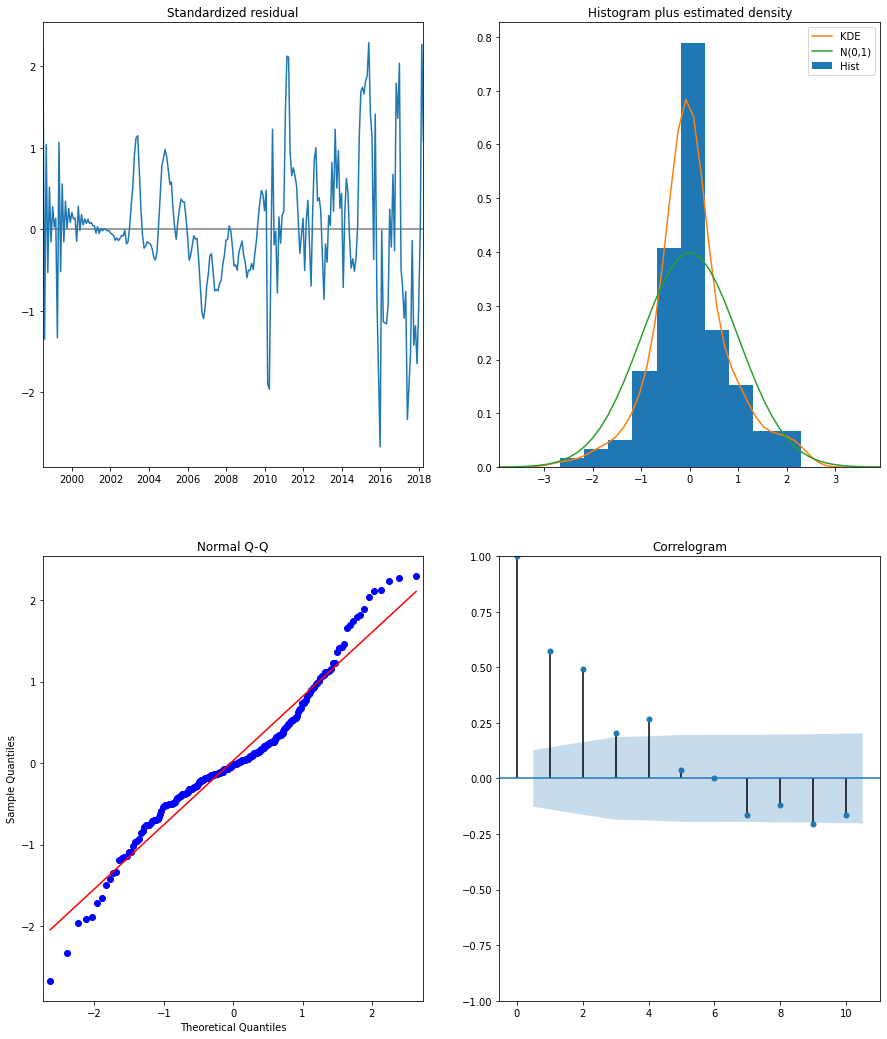

In [45]:
zipcode_osa = 11218
zip_params= output_df[output_df['zipcode']==zipcode_osa]
zip_params.pdq.values[0]
zip_params.seasonal_pdq.values[0]

output_sarima = fit_ARIMA(zip_df[zipcode_osa],order=zip_params.pdq.values[0], seasonal_order= zip_params.seasonal_pdq.values[0] )

pred = output_sarima.get_prediction(start=pd.to_datetime('2014-01-01'), dynamic=False)
pred_conf = pred.conf_int()

In [46]:
zip_params = output_df[output_df['zipcode']==11218]
zip_params

,zipcode,pdq,seasonal_pdq,aic
13,11218,"(0, 1, 1)","(1, 1, 1, 12)",5290.561381


In [47]:
zip_params.columns

Index(['zipcode', 'pdq', 'seasonal_pdq', 'aic'], dtype='object')

In [48]:
zip_params['pdq']

13    (0, 1, 1)
Name: pdq, dtype: object

In [49]:
zip_params.pdq.values[0]

(0, 1, 1)

#### Plot of One-Step-Ahead Forecasting

Below is a plot of the real and forecasted values of the time series to assess how well the model did.  The plot icludes the confidence intervals which in this case overlap the predicted values.  The mean prediction is marked with the orange line.  The uncertainy range is shaded in green.  The uncertainty is due the the random terms that can't be predicted. 

The central value of the forecast is stored in the .predicted_mean attribute of the pred object.

the method .fill_between() produces the shade area between our lower and upper limits.

Visually it looks like the model did pretty good at making the predictions for zipcode 11218 because the forecasts align with the true test set values.

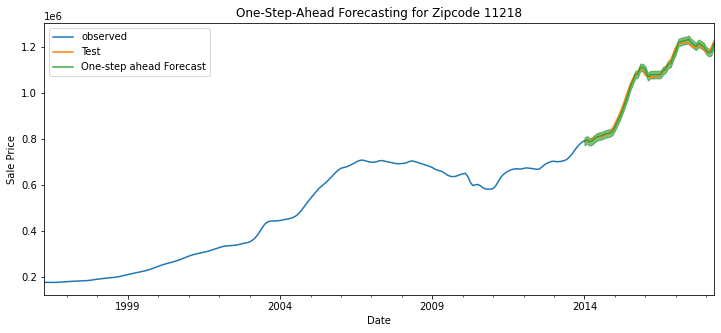

In [50]:
plt.figure(figsize=(12,5))
# Plot observed values
ax = train_brk[11218].plot(label='observed')
test_brk[11218].plot(label='Test')
# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Sale Price')
plt.title(f'One-Step-Ahead Forecasting for Zipcode {zipcode_osa}')
plt.legend();

#### Check the Model's Accuracy

I will check the models' accuracy in making the prediction by using the metric RMSE (Mean Squared Error).  RMSE is the standard deviation of the residuals (prediction errors). Residuals are a measure of how far from the regression line data points are.  RMSE is a measure of how spread out these residuals are. It tells us how concentrated the data is around the line of best fit.

Model was able to forecast the average daily real estate sales in the test set within 10,607.48 of the real sales.  The sales in this zip code 11218 range from around 1,003,700.00 to 2,202,400.00.  

In [51]:
# Get the real and predicted values
forecasted_11238 = pred.predicted_mean
truth_1128 =test_brk[11218]['1996':]

# Compute the root mean square error
mse = ((forecasted_11238 - truth_1128) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
#np.sqrt(np.mean((predictions-targets)**2))
rmse = np.sqrt(np.mean((forecasted_11238 - truth_1128) ** 2))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(rmse, 2)))

The Mean Squared Error of our forecasts is 114452896.13
The Root Mean Squared Error of our forecasts is 10698.27


In [52]:
train_brk[zipcode].describe().round(3)

count        214.000
mean     1319126.636
std       314705.269
min      1003700.000
25%      1037600.000
50%      1167000.000
75%      1567600.000
max      2202400.000
Name: 11217, dtype: float64

### Dynamic Forecasting

We can make predictioned further than just One-Step-Ahead. We predict One-Step-Ahead and use this predicted value to forecast the next value after that.  We build the forecast on forecasted data.  We can predcit into the future.  We don't don't know the shock term after that so the uncertainy level can grow quickly. The more we base the next prediction off of a predictd value the broader the confidence interval will get.  The farther away we get from last true value the less we can trust the prediction.  The mpore prone ot errors.

The dynamic is set to True

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              11218   No. Observations:                  265
Model:             SARIMAX(0, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -2444.160
Date:                            Mon, 12 Jul 2021   AIC                           4896.320
Time:                                    20:04:03   BIC                           4910.209
Sample:                                04-01-1996   HQIC                          4901.917
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.6674      0.042     15.751      0.000       0.584       0.750
ar.S.L12      -0.3940      0.103     -3.832      0.000      -0.596      -0.192
ma.S.L12      -0.1906      0.081     -2.367      0.018      -0.348      -0.033
sigma2      7.123e+07    1.5e-10   4.76e+17      0.000    7.12e+07    7.12e+07
===================================================================================
Ljung-Box (Q):                      377.37   Jarque-Bera (JB):                21.93
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               4.17   Skew:                             0.21
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.77e+34. Standard errors may be unstable.
"""



MODEL DIAGNOSTICS


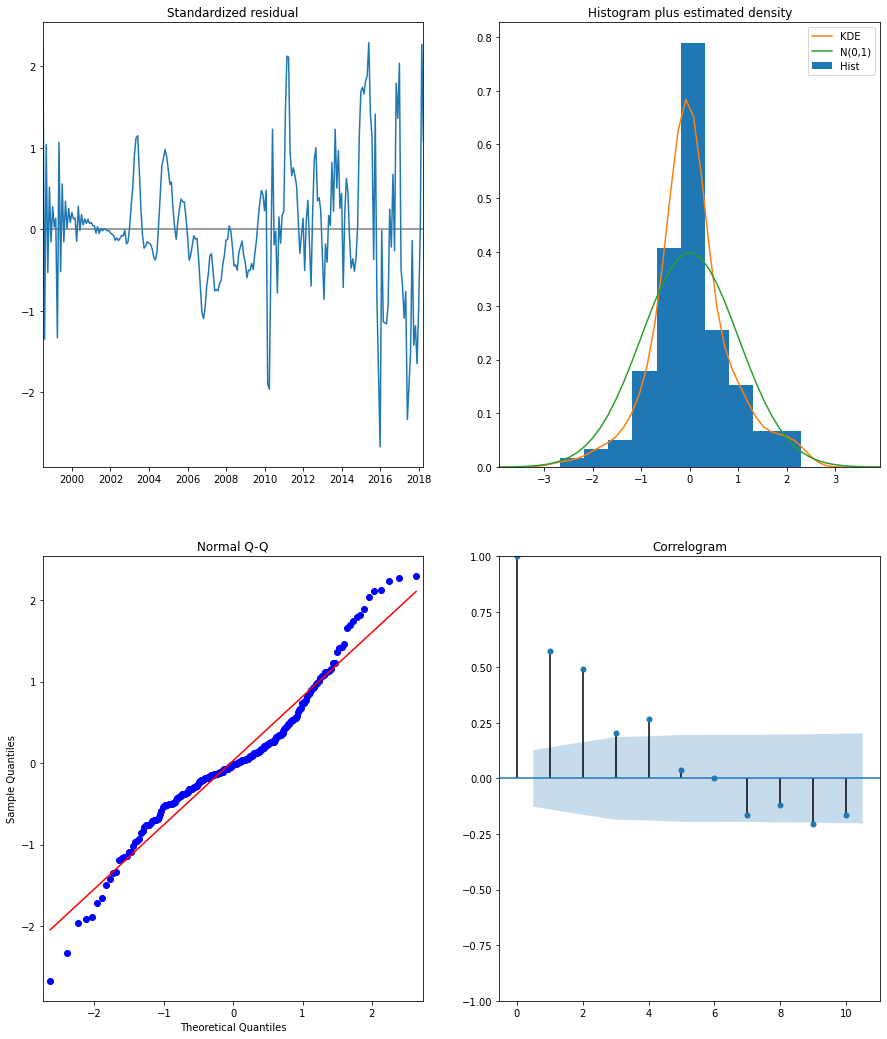

In [53]:
zipcode_df = 11218
zip_params = output_df[output_df['zipcode']== zipcode_df]
zip_params.pdq.values[0]
zip_params.seasonal_pdq.values[0]

output_sarima = fit_ARIMA(zip_df[zipcode_df ],order=zip_params.pdq.values[0] ,seasonal_order= zip_params.seasonal_pdq.values[0] )
# Get dynamic predictions with confidence intervals 
pred_dynamic = output_sarima.get_prediction(start=pd.to_datetime('2014-01-01'), dynamic=True,full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

Plotting the observed and forecasted values of the time series, we see that the overall forecasts are accurate even when using Dynamic Forecasting.  Model was able to forecast the average daily real estate sales in the test set within 3724.22 of the real sales.   

In [54]:

def prediction_vis(pred_dynamic,pred_dynamic_conf, y):
  # Plot the dynamic forecast with confidence intervals.
  plt.figure(figsize=(12,5))
  # Plot observed values
  ax = y.plot(label='Observed')

  # Plot predicted values
  pred_dynamic.predicted_mean.plot(ax=ax, label='Dynamic Forecast', alpha=0.9)

  # Plot the range for confidence intervals
  ax.fill_between(pred_dynamic_conf.index,
                  pred_dynamic_conf.iloc[:, 0],
                  pred_dynamic_conf.iloc[:, 1], color='g', alpha=0.5)

  # Set axes labels
  ax.set_xlabel('Date')
  ax.set_ylabel('Sale Price')
  plt.legend()

  return ax

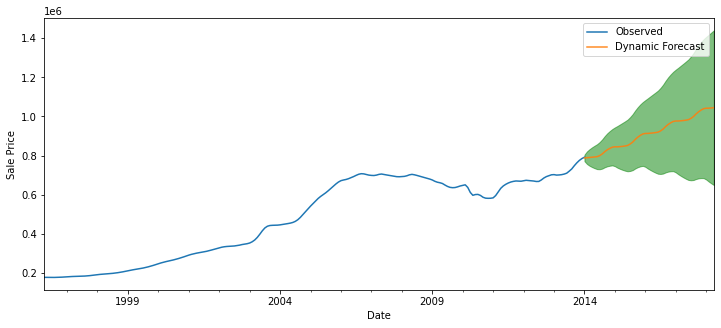

In [55]:
prediction_visual = prediction_vis(pred_dynamic,pred_dynamic_conf,train_brk[zipcode_df])
prediction_visual

In [56]:
# Get the real and predicted values
forecast_11238 = pred_dynamic.predicted_mean
truth_11238 = train_brk[zipcode_df]#['1996':]

# Compute the mean square error
mse = ((forecast_11238 - truth_11238) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
#np.sqrt(np.mean((predictions-targets)**2))
rmse = np.sqrt(np.mean((forecast_11238 - truth_11238) ** 2))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(rmse, 2)))

The Mean Squared Error of our forecasts is 13869796.0
The Root Mean Squared Error of our forecasts is 3724.22


### Forecasts
Use ARIMA model to forecast future values.  We need to tell.  We are forecasting beyond the time series.  Wil go into the future form the end of time eries dataset.  The .get_forecast() method of our time series output can compute forecasted values for a specified number of steps ahead.  Forecasting much furtehr out into the futre tha nwe had data for.  The farther away we get form true vlaues the wider hte confidence intevals get.

Don't just concentrate on predicted mean.  There's a chance that you could lose money by falling negtive side of confidence interval

In [57]:
steps = 300
# Get forecast --- steps ahead in future
prediction_object = output_sarima.get_forecast(steps=steps, dynamic=True)
#prediction_object.predicted_mean

predict_conf = prediction_object.conf_int()

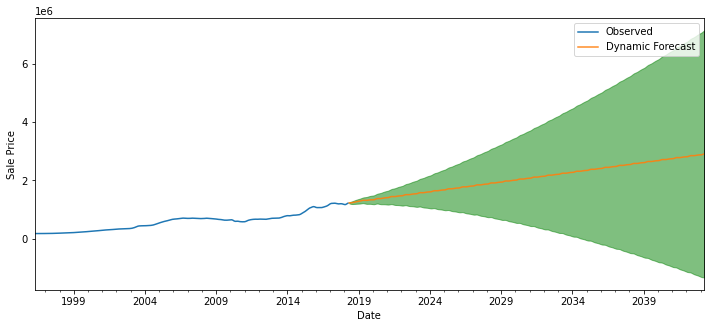

In [58]:
#plot future predictions with confiedence intervals
prediction_visual_2 = prediction_vis(prediction_object,predict_conf,zip_df[zipcode_df])
prediction_visual_2

### **Return on Investment DataFrame**
The method .get_forecast() computes the forecasted values for a specified number of steps ahead.<br>

The method .conf_int() gets the confidence intervals of forecasts.<br>


In [59]:
# Get forecast --- steps ahead in future
prediction = output_sarima.get_forecast(steps=36, dynamic=True)
prediction.predicted_mean

# Get confidence intervals of forecasts
predict_conf = prediction.conf_int()


In [60]:
steps = 36
# Get forecast --- steps ahead in future
prediction_object = output_sarima.get_forecast(steps=steps, dynamic=True)

In [61]:
def my_function(prediction_object, zip):
  """
  function gets ROI for 1 zipcode 
  """
  df_Summary = pd.concat([pd.DataFrame({f'Predicted_Mean {zip}':prediction_object.predicted_mean}), prediction_object.conf_int()],axis = 1)
  df_Summary
  # my_sample = df_Summary.iloc[[0, -1]].round(3)
  my_sample = df_Summary.iloc[[0, -1]].round(3) #1st and last

  return my_sample  #df_Summary


In [62]:
my_output = my_function(prediction_object, zip='11218')
my_output

,Predicted_Mean 11218,lower 11218,upper 11218
2018-05-01,1231799.938,1215258.766,1248341.109
2021-04-01,1441142.690,1186954.618,1695330.761


In [63]:

def my_roi(cost, current):
  """  
  function to calculate ROI 
  ROI= 
  Cost of Investment
  Current Value of Investment−Cost of Investment
  """
  return (current - cost) / cost


In [64]:
cost = my_output.iloc[0,0]
current = my_output.iloc[-1,0]

In [65]:

current_lower = my_output.iloc[-1,1]
current_upper = my_output.iloc[-1,2]

In [66]:
#upper lower end
roi_dic = {}

cost = my_output.iloc[0,0]
current = my_output.iloc[-1,0]
current_lower = my_output.iloc[-1,1]
current_upper = my_output.iloc[-1,2]


my_roi(cost, current)
roi_dic['roi'] = my_roi(cost, current)
roi_dic['roi_lower'] = my_roi(cost, current_lower)
roi_dic['roi_upper'] = my_roi(cost, current_upper)

roi_dic

{'roi': 0.16994866255627286,
 'roi_lower': -0.03640633402921965,
 'roi_upper': 0.37630365832994533}

In [67]:
my_output

,Predicted_Mean 11218,lower 11218,upper 11218
2018-05-01,1231799.938,1215258.766,1248341.109
2021-04-01,1441142.690,1186954.618,1695330.761


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                11226   No. Observations:                  265
Model:             SARIMAX(2, 0, 0)x(2, 1, [1], 12)   Log Likelihood               -2258.133
Date:                              Mon, 12 Jul 2021   AIC                           4528.266
Time:                                      20:04:10   BIC                           4548.815
Sample:                                  04-01-1996   HQIC                          4536.558
                                       - 04-01-2018                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.8035      0.052     34.737      0.000       1.702       1.905
ar.L2         -0.8041      0.053    -15.232      0.000      -0.908      -0.701
ar.S.L12      -0.8367      0.109     -7.708      0.000      -1.049      -0.624
ar.S.L24      -0.4480      0.126     -3.552      0.000      -0.695      -0.201
ma.S.L12      -0.0706      0.080     -0.884      0.377      -0.227       0.086
sigma2       3.56e+07   7.48e-10   4.76e+16      0.000    3.56e+07    3.56e+07
===================================================================================
Ljung-Box (Q):                      177.40   Jarque-Bera (JB):               150.62
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              21.43   Skew:                             0.38
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.93e+32. Standard errors may be unstable.
"""



MODEL DIAGNOSTICS


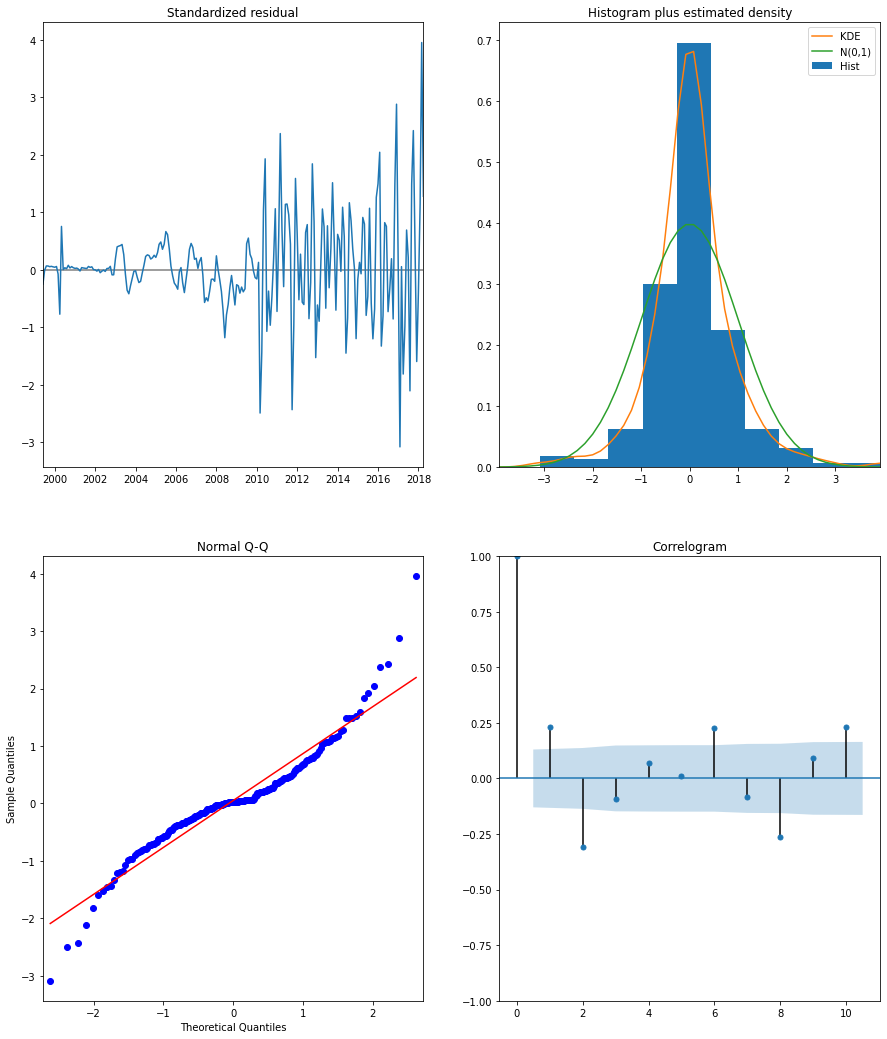

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                11235   No. Observations:                  265
Model:             SARIMAX(1, 1, 0)x(1, 1, [1], 12)   Log Likelihood               -2193.358
Date:                              Mon, 12 Jul 2021   AIC                           4394.715
Time:                                      20:04:12   BIC                           4408.621
Sample:                                  04-01-1996   HQIC                          4400.319
                                       - 04-01-2018                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8416      0.031     27.148      0.000       0.781       0.902
ar.S.L12      -0.4782      0.069     -6.912      0.000      -0.614      -0.343
ma.S.L12      -0.0372      0.043     -0.862      0.389      -0.122       0.047
sigma2      5.471e+06   3.34e+05     16.361      0.000    4.82e+06    6.13e+06
===================================================================================
Ljung-Box (Q):                      187.79   Jarque-Bera (JB):                78.04
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              20.36   Skew:                             0.18
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""



MODEL DIAGNOSTICS


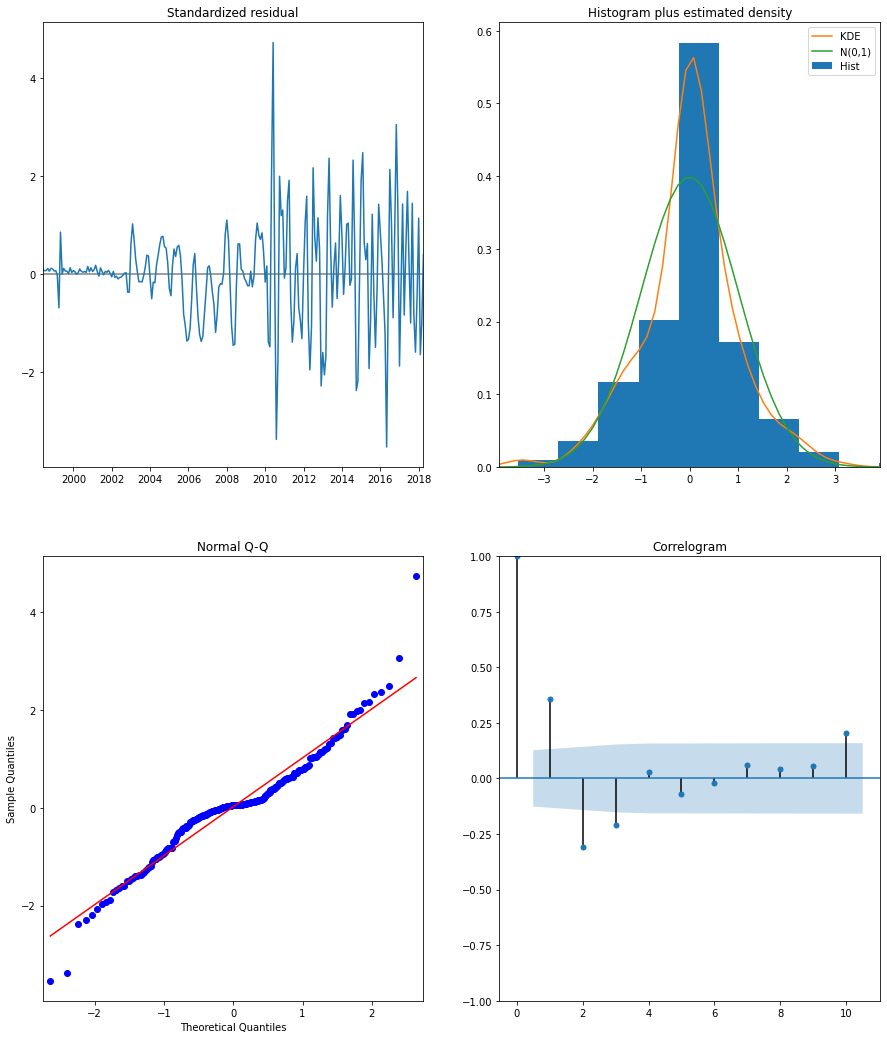

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                11230   No. Observations:                  265
Model:             SARIMAX(1, 1, 0)x(2, 1, [1], 12)   Log Likelihood               -2160.080
Date:                              Mon, 12 Jul 2021   AIC                           4330.159
Time:                                      20:04:16   BIC                           4347.284
Sample:                                  04-01-1996   HQIC                          4337.069
                                       - 04-01-2018                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8902      0.043     20.802      0.000       0.806       0.974
ar.S.L12      -0.6404      0.124     -5.179      0.000      -0.883      -0.398
ar.S.L24      -0.2941      0.092     -3.193      0.001      -0.475      -0.114
ma.S.L12      -0.0660      0.082     -0.805      0.421      -0.227       0.095
sigma2      1.367e+07   1.16e+06     11.786      0.000    1.14e+07    1.59e+07
===================================================================================
Ljung-Box (Q):                      148.45   Jarque-Bera (JB):                60.94
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               4.31   Skew:                             0.36
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""



MODEL DIAGNOSTICS


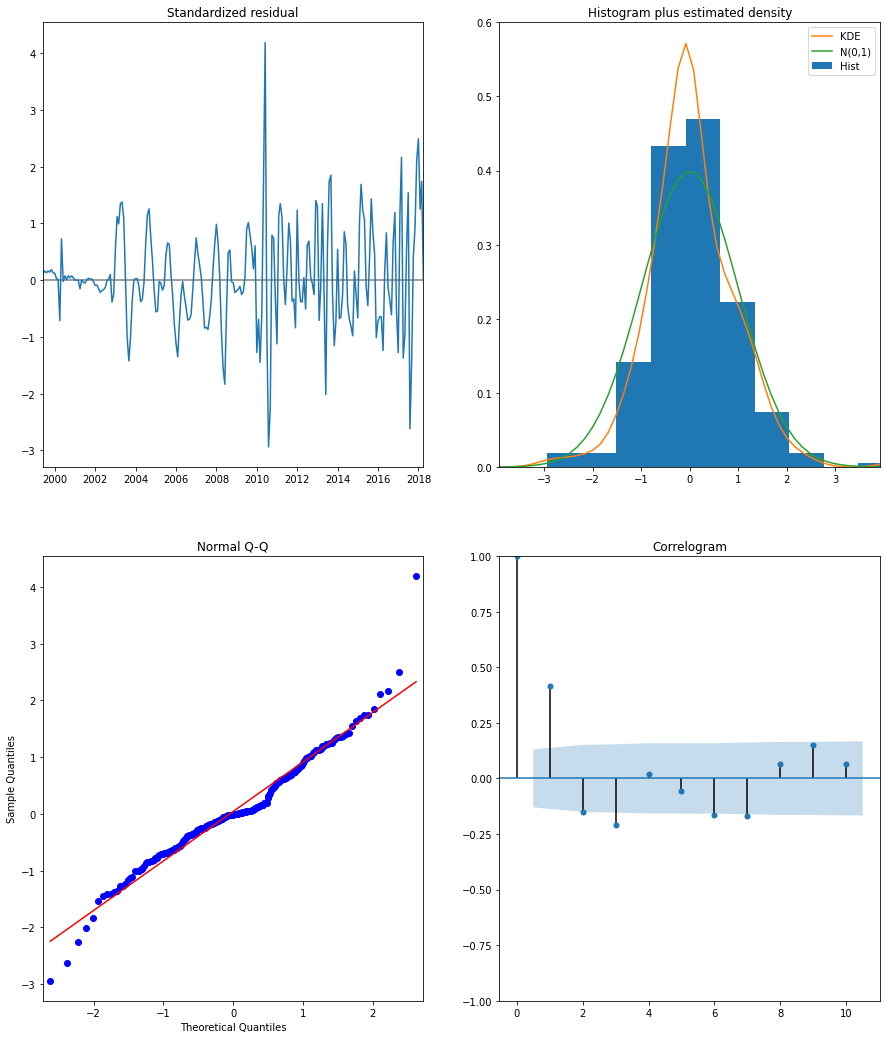

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                   11209   No. Observations:                  265
Model:             SARIMAX(0, 1, 1)x(2, 1, [1, 2], 12)   Log Likelihood               -2216.342
Date:                                 Mon, 12 Jul 2021   AIC                           4444.683
Time:                                         20:04:24   BIC                           4465.207
Sample:                                     04-01-1996   HQIC                          4452.966
                                          - 04-01-2018                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          1.0439      0.018     57.746      0.000       1.008       1.079
ar.S.L12       0.0811      0.164      0.495      0.620      -0.240       0.402
ar.S.L24      -0.0575      0.107     -0.536      0.592      -0.268       0.153
ma.S.L12      -0.6260      0.182     -3.444      0.001      -0.982      -0.270
ma.S.L24       0.1605      0.148      1.083      0.279      -0.130       0.451
sigma2      2.482e+07   2.03e-09   1.22e+16      0.000    2.48e+07    2.48e+07
===================================================================================
Ljung-Box (Q):                      209.78   Jarque-Bera (JB):                 4.80
Prob(Q):                              0.00   Prob(JB):                         0.09
Heteroskedasticity (H):               5.34   Skew:                            -0.13
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.91e+32. Standard errors may be unstable.
"""



MODEL DIAGNOSTICS


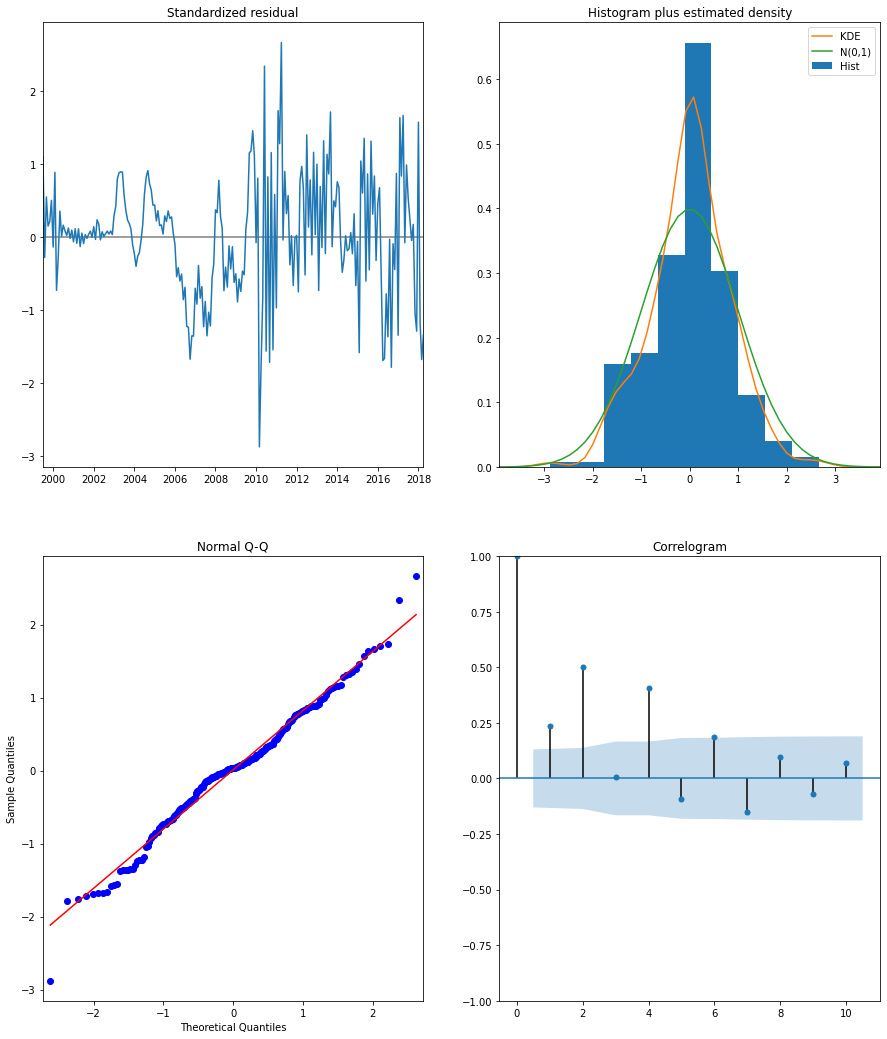

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              11212   No. Observations:                  265
Model:             SARIMAX(3, 1, 0)x(2, 1, 0, 12)   Log Likelihood               -1869.543
Date:                            Mon, 12 Jul 2021   AIC                           3751.087
Time:                                    20:04:34   BIC                           3771.583
Sample:                                04-01-1996   HQIC                          3759.359
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.7565      0.064     27.390      0.000       1.631       1.882
ar.L2         -1.2216      0.107    -11.426      0.000      -1.431      -1.012
ar.L3          0.3915      0.056      7.001      0.000       0.282       0.501
ar.S.L12      -0.7358      0.062    -11.954      0.000      -0.856      -0.615
ar.S.L24      -0.4012      0.054     -7.453      0.000      -0.507      -0.296
sigma2      9.655e+05   6.64e+04     14.540      0.000    8.35e+05     1.1e+06
===================================================================================
Ljung-Box (Q):                      117.46   Jarque-Bera (JB):               134.22
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               5.51   Skew:                             0.47
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""



MODEL DIAGNOSTICS


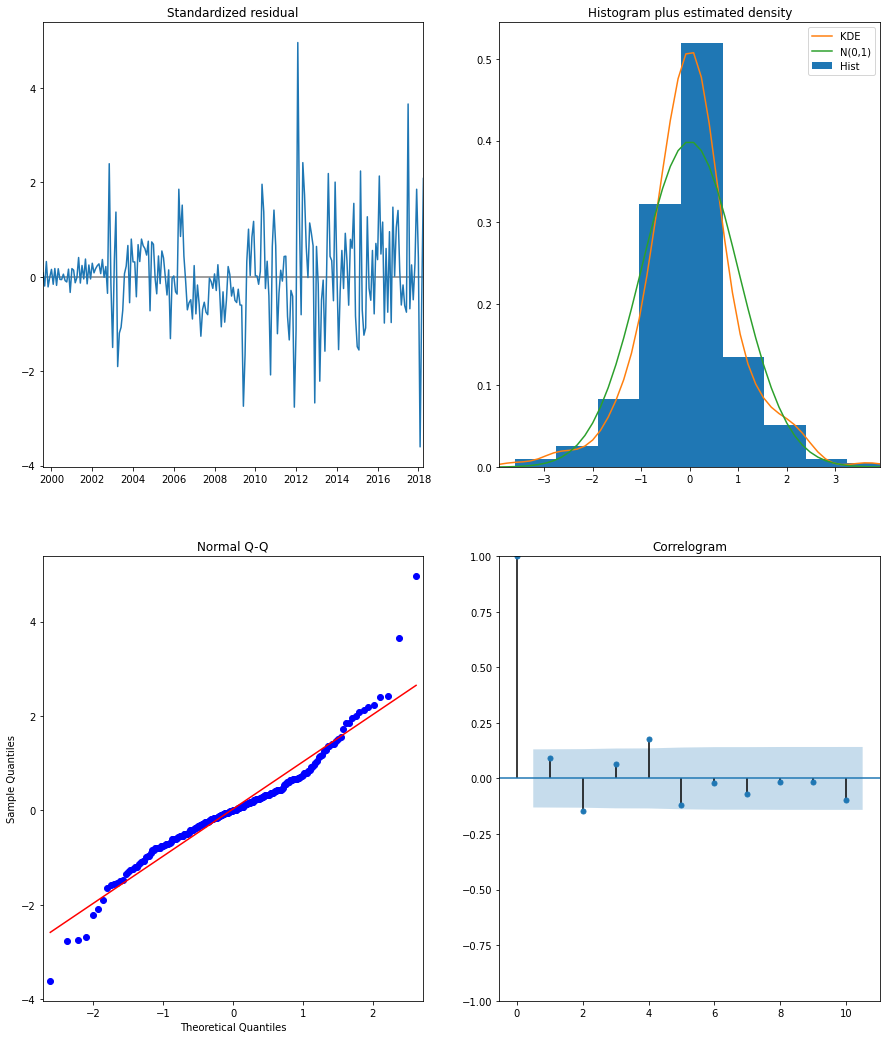

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                11214   No. Observations:                  265
Model:             SARIMAX(2, 1, 0)x(2, 1, [1], 12)   Log Likelihood               -2050.998
Date:                              Mon, 12 Jul 2021   AIC                           4113.996
Time:                                      20:04:36   BIC                           4134.519
Sample:                                  04-01-1996   HQIC                          4122.278
                                       - 04-01-2018                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3142      0.063     20.751      0.000       1.190       1.438
ar.L2         -0.5413      0.064     -8.474      0.000      -0.666      -0.416
ar.S.L12      -0.8011      0.155     -5.179      0.000      -1.104      -0.498
ar.S.L24      -0.3656      0.104     -3.500      0.000      -0.570      -0.161
ma.S.L12      -0.0170      0.119     -0.144      0.886      -0.249       0.215
sigma2      6.301e+06    6.1e+05     10.327      0.000    5.11e+06     7.5e+06
===================================================================================
Ljung-Box (Q):                      147.68   Jarque-Bera (JB):                91.95
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              25.32   Skew:                            -0.02
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""



MODEL DIAGNOSTICS


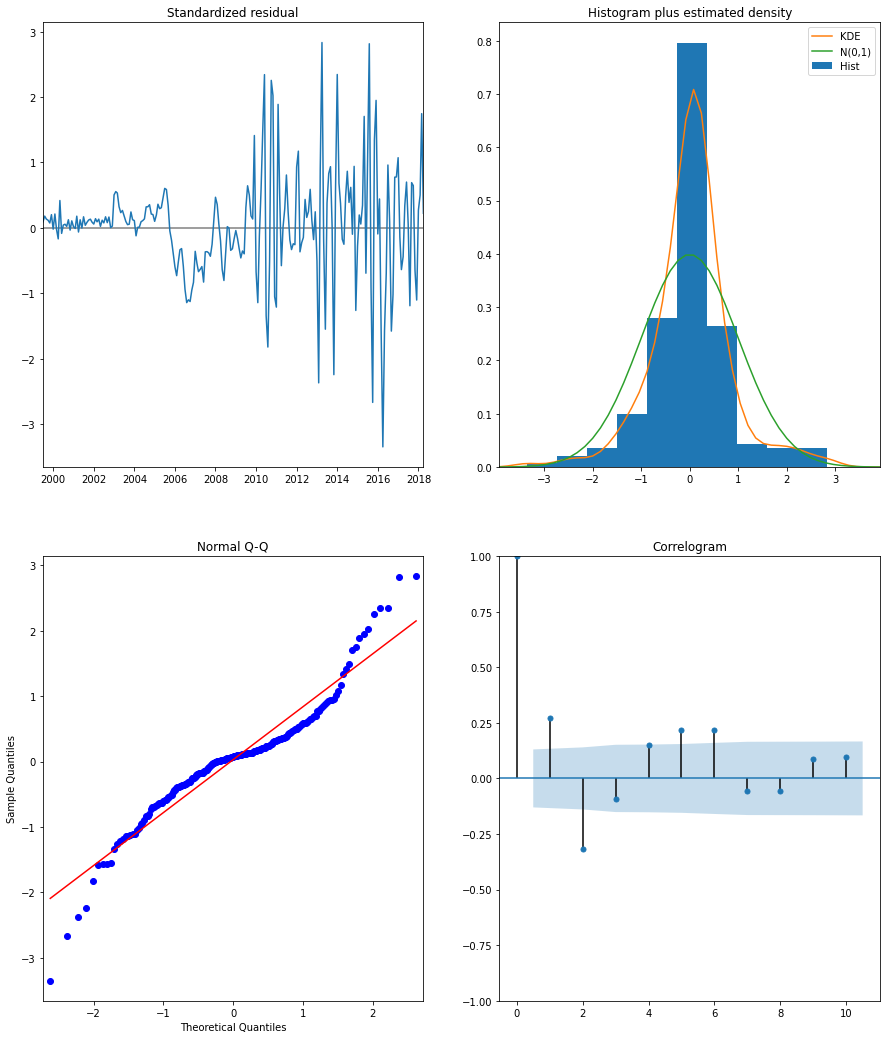

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                11221   No. Observations:                  265
Model:             SARIMAX(2, 2, 2)x(1, 1, [1], 12)   Log Likelihood               -2205.692
Date:                              Mon, 12 Jul 2021   AIC                           4425.383
Time:                                      20:04:38   BIC                           4449.630
Sample:                                  04-01-1996   HQIC                          4435.157
                                       - 04-01-2018                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1386      0.142      0.974      0.330      -0.140       0.417
ar.L2         -0.5222      0.072     -7.301      0.000      -0.662      -0.382
ma.L1          0.3922      0.148      2.656      0.008       0.103       0.682
ma.L2          0.0631      0.092      0.685      0.494      -0.118       0.244
ar.S.L12      -0.7633      0.085     -9.023      0.000      -0.929      -0.597
ma.S.L12      -0.0126      0.092     -0.136      0.892      -0.194       0.169
sigma2      1.005e+07      7e+05     14.351      0.000    8.68e+06    1.14e+07
===================================================================================
Ljung-Box (Q):                       83.81   Jarque-Bera (JB):               659.14
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              28.69   Skew:                             0.17
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.84e+14. Standard errors may be unstable.
"""



MODEL DIAGNOSTICS


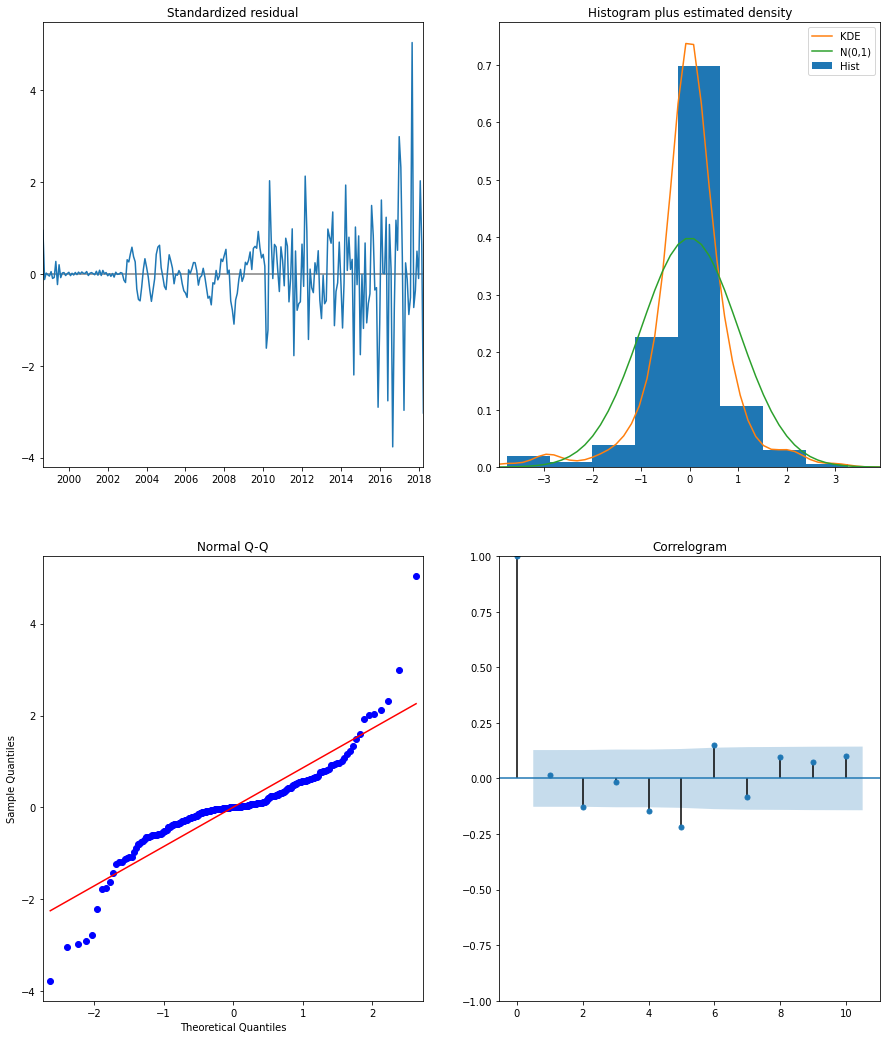

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              11229   No. Observations:                  265
Model:             SARIMAX(2, 1, 0)x(2, 1, 0, 12)   Log Likelihood               -1975.562
Date:                            Mon, 12 Jul 2021   AIC                           3961.125
Time:                                    20:04:42   BIC                           3978.227
Sample:                                04-01-1996   HQIC                          3968.027
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3062      0.036     35.927      0.000       1.235       1.377
ar.L2         -0.4577      0.037    -12.445      0.000      -0.530      -0.386
ar.S.L12      -0.7020      0.056    -12.559      0.000      -0.812      -0.592
ar.S.L24      -0.4326      0.065     -6.652      0.000      -0.560      -0.305
sigma2      2.292e+06   1.58e+05     14.515      0.000    1.98e+06     2.6e+06
===================================================================================
Ljung-Box (Q):                      139.66   Jarque-Bera (JB):                89.20
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              10.56   Skew:                             0.62
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""



MODEL DIAGNOSTICS


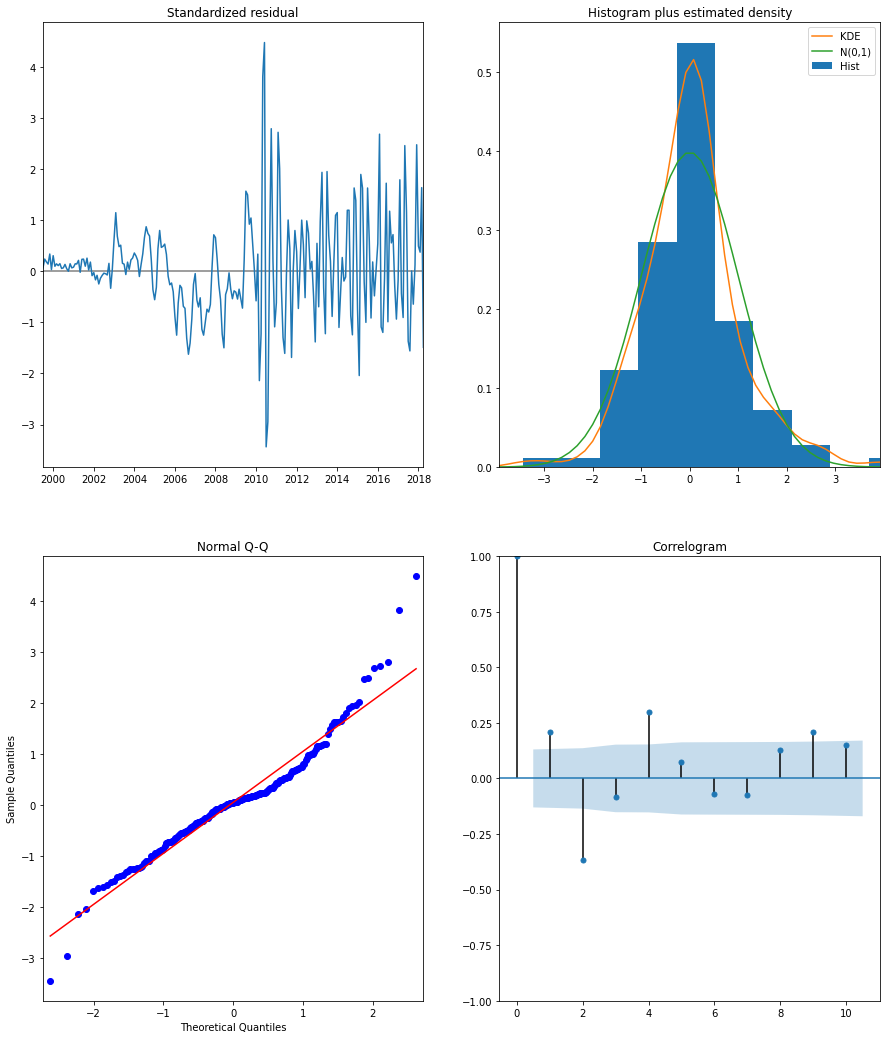

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              11234   No. Observations:                  265
Model:             SARIMAX(2, 1, 0)x(2, 1, 0, 12)   Log Likelihood               -1975.003
Date:                            Mon, 12 Jul 2021   AIC                           3960.005
Time:                                    20:04:44   BIC                           3977.108
Sample:                                04-01-1996   HQIC                          3966.907
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2331      0.048     25.756      0.000       1.139       1.327
ar.L2         -0.4501      0.055     -8.235      0.000      -0.557      -0.343
ar.S.L12      -0.6156      0.075     -8.259      0.000      -0.762      -0.470
ar.S.L24      -0.3202      0.065     -4.904      0.000      -0.448      -0.192
sigma2      2.706e+06   2.35e+05     11.518      0.000    2.25e+06    3.17e+06
===================================================================================
Ljung-Box (Q):                      200.17   Jarque-Bera (JB):               100.70
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              10.99   Skew:                             0.52
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""



MODEL DIAGNOSTICS


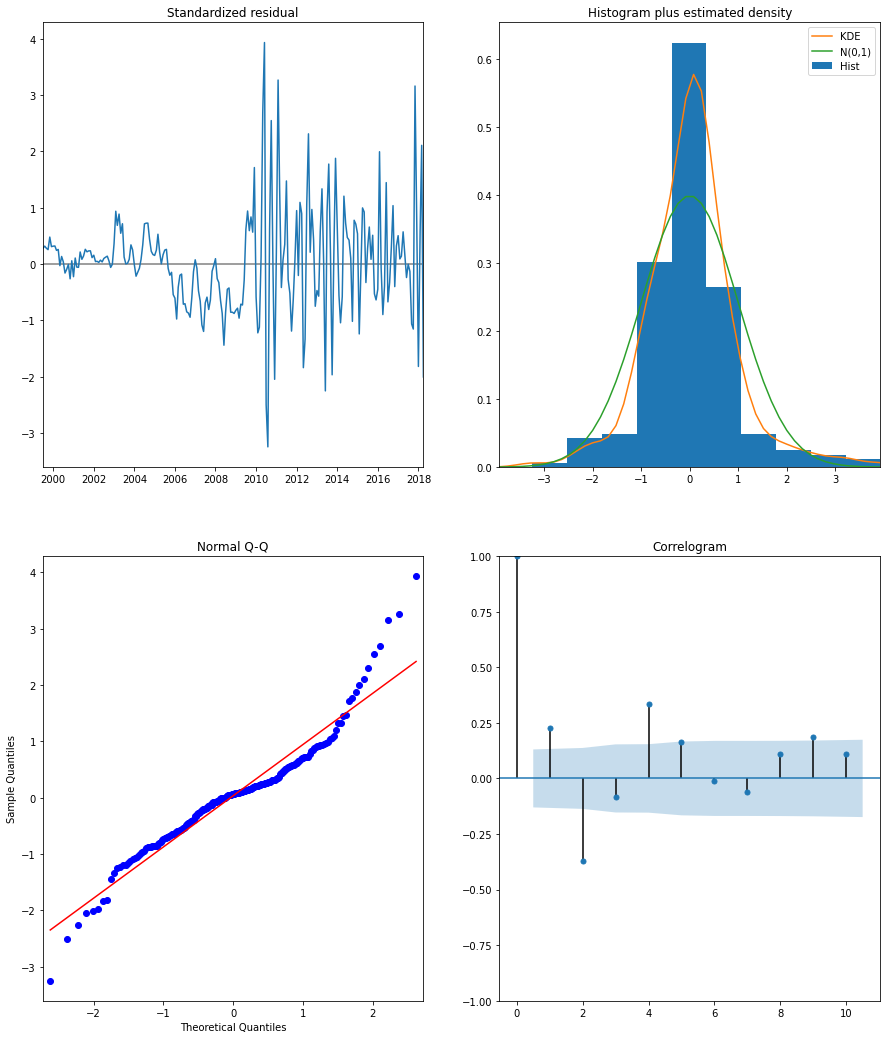

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                   11215   No. Observations:                  265
Model:             SARIMAX(3, 0, 0)x(0, 1, [1, 2], 12)   Log Likelihood               -2816.046
Date:                                 Mon, 12 Jul 2021   AIC                           5644.092
Time:                                         20:04:48   BIC                           5664.668
Sample:                                     04-01-1996   HQIC                          5652.394
                                          - 04-01-2018                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          2.2050      0.042     53.045      0.000       2.124       2.287
ar.L2         -1.7726      0.082    -21.524      0.000      -1.934      -1.611
ar.L3          0.5280      0.049     10.885      0.000       0.433       0.623
ma.S.L12       8.6627      0.200     43.215      0.000       8.270       9.056
ma.S.L24       4.2611      1.487      2.866      0.004       1.347       7.175
sigma2      7.421e+07   7.21e-08   1.03e+15      0.000    7.42e+07    7.42e+07
===================================================================================
Ljung-Box (Q):                      156.26   Jarque-Bera (JB):             14236.54
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.04   Skew:                             4.73
Prob(H) (two-sided):                  0.00   Kurtosis:                        40.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.63e+30. Standard errors may be unstable.
"""



MODEL DIAGNOSTICS


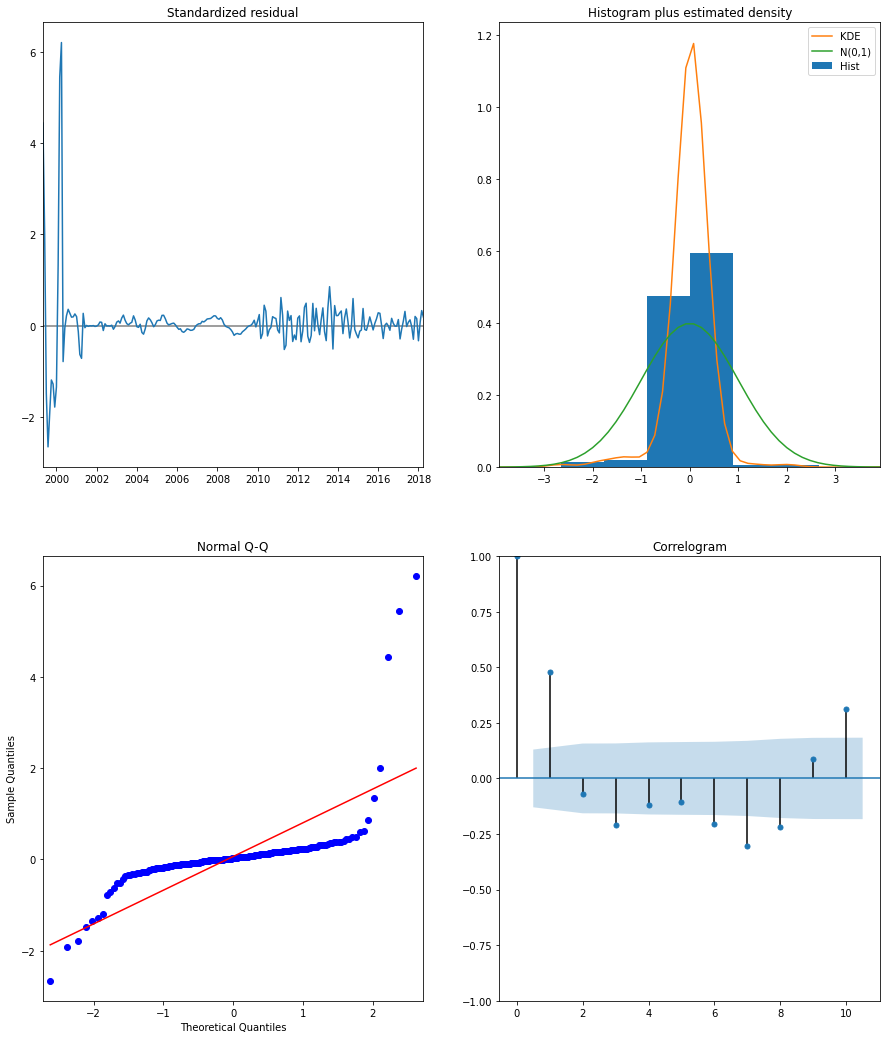

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               11211   No. Observations:                  265
Model:             SARIMAX(2, 0, 1)x(2, 1, [], 12)   Log Likelihood               -2342.400
Date:                             Mon, 12 Jul 2021   AIC                           4696.800
Time:                                     20:04:53   BIC                           4717.349
Sample:                                 04-01-1996   HQIC                          4705.092
                                      - 04-01-2018                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.5520      0.086     17.976      0.000       1.383       1.721
ar.L2         -0.5515      0.087     -6.338      0.000      -0.722      -0.381
ma.L1          0.5140      0.076      6.727      0.000       0.364       0.664
ar.S.L12      -0.9085      0.077    -11.800      0.000      -1.059      -0.758
ar.S.L24      -0.3268      0.063     -5.188      0.000      -0.450      -0.203
sigma2      8.057e+07   4.01e-10   2.01e+17      0.000    8.06e+07    8.06e+07
===================================================================================
Ljung-Box (Q):                       75.74   Jarque-Bera (JB):                39.31
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              10.55   Skew:                            -0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.5e+34. Standard errors may be unstable.
"""



MODEL DIAGNOSTICS


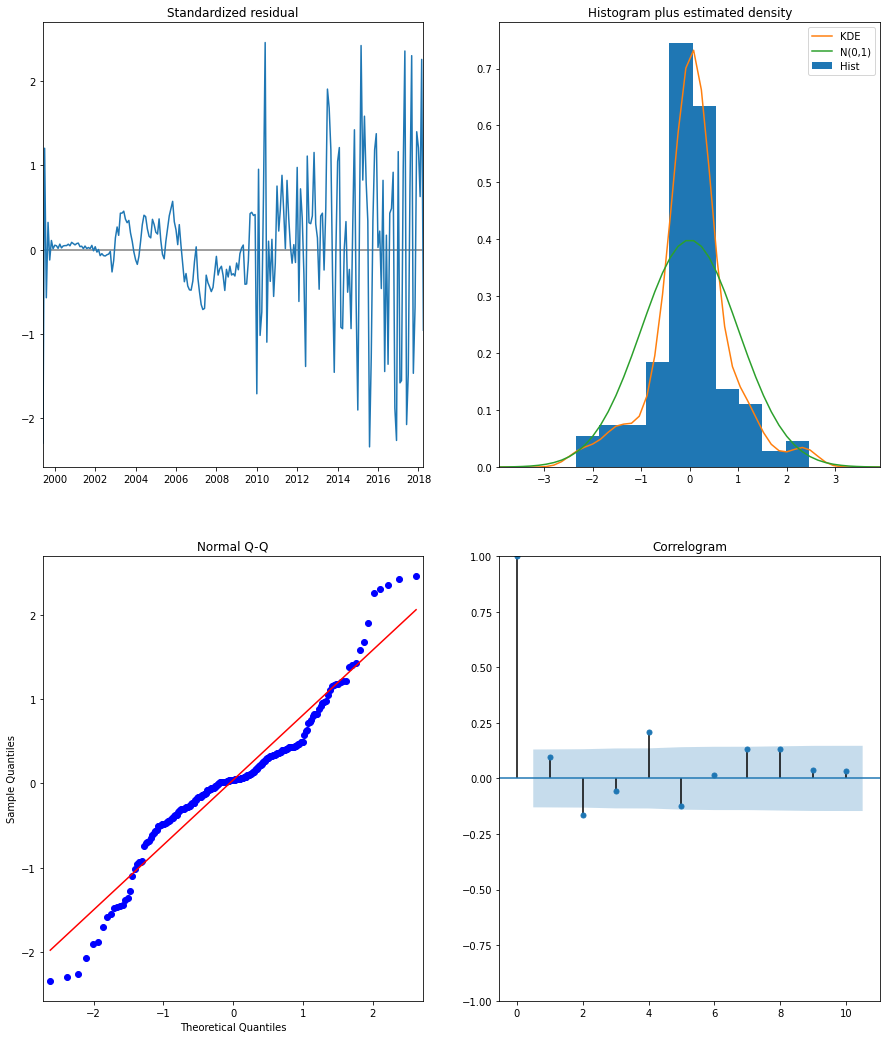

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                11233   No. Observations:                  265
Model:             SARIMAX(1, 1, 0)x(1, 1, [1], 12)   Log Likelihood               -2299.125
Date:                              Mon, 12 Jul 2021   AIC                           4606.250
Time:                                      20:04:55   BIC                           4620.156
Sample:                                  04-01-1996   HQIC                          4611.854
                                       - 04-01-2018                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8020      0.039     20.561      0.000       0.726       0.878
ar.S.L12      -0.6376      0.075     -8.514      0.000      -0.784      -0.491
ma.S.L12      -0.0592      0.075     -0.790      0.429      -0.206       0.088
sigma2      1.724e+07   8.23e-10    2.1e+16      0.000    1.72e+07    1.72e+07
===================================================================================
Ljung-Box (Q):                      151.87   Jarque-Bera (JB):               272.90
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              42.42   Skew:                             0.89
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.65e+31. Standard errors may be unstable.
"""



MODEL DIAGNOSTICS


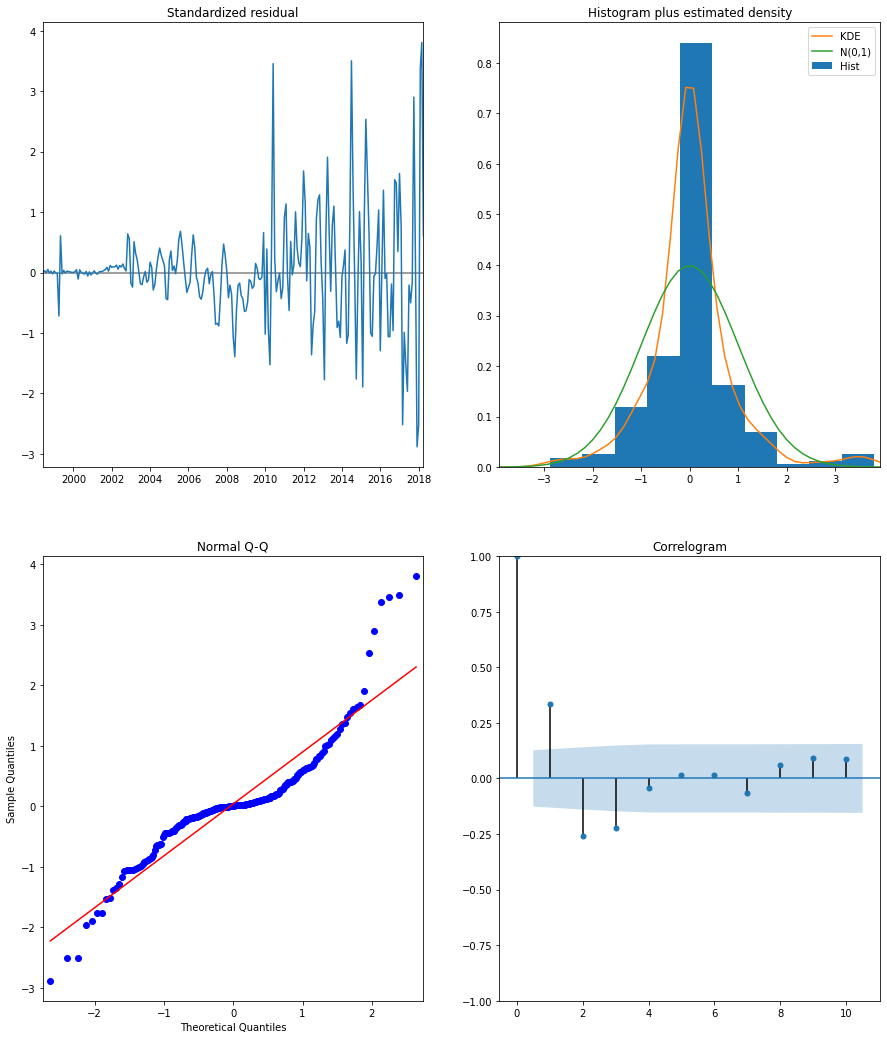

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                11236   No. Observations:                  265
Model:             SARIMAX(1, 1, 0)x(2, 1, [1], 12)   Log Likelihood               -2010.581
Date:                              Mon, 12 Jul 2021   AIC                           4031.162
Time:                                      20:04:57   BIC                           4048.287
Sample:                                  04-01-1996   HQIC                          4038.072
                                       - 04-01-2018                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8880      0.040     22.410      0.000       0.810       0.966
ar.S.L12      -0.6342      0.113     -5.612      0.000      -0.856      -0.413
ar.S.L24      -0.3009      0.102     -2.964      0.003      -0.500      -0.102
ma.S.L12      -0.0498      0.085     -0.587      0.557      -0.216       0.116
sigma2      3.686e+06   3.85e+05      9.581      0.000    2.93e+06    4.44e+06
===================================================================================
Ljung-Box (Q):                      139.58   Jarque-Bera (JB):                 8.30
Prob(Q):                              0.00   Prob(JB):                         0.02
Heteroskedasticity (H):               8.69   Skew:                             0.25
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""



MODEL DIAGNOSTICS


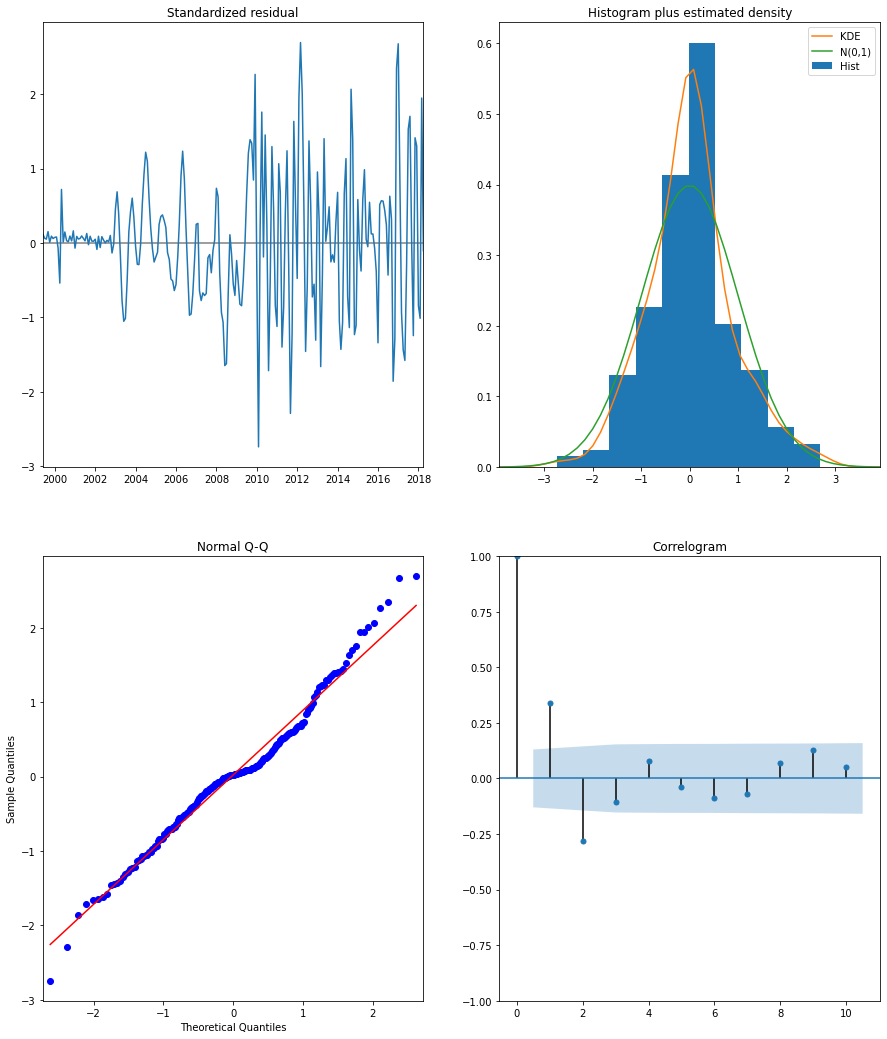

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              11218   No. Observations:                  265
Model:             SARIMAX(0, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -2444.160
Date:                            Mon, 12 Jul 2021   AIC                           4896.320
Time:                                    20:04:59   BIC                           4910.209
Sample:                                04-01-1996   HQIC                          4901.917
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.6674      0.042     15.751      0.000       0.584       0.750
ar.S.L12      -0.3940      0.103     -3.832      0.000      -0.596      -0.192
ma.S.L12      -0.1906      0.081     -2.367      0.018      -0.348      -0.033
sigma2      7.123e+07    1.5e-10   4.76e+17      0.000    7.12e+07    7.12e+07
===================================================================================
Ljung-Box (Q):                      377.37   Jarque-Bera (JB):                21.93
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               4.17   Skew:                             0.21
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.77e+34. Standard errors may be unstable.
"""



MODEL DIAGNOSTICS


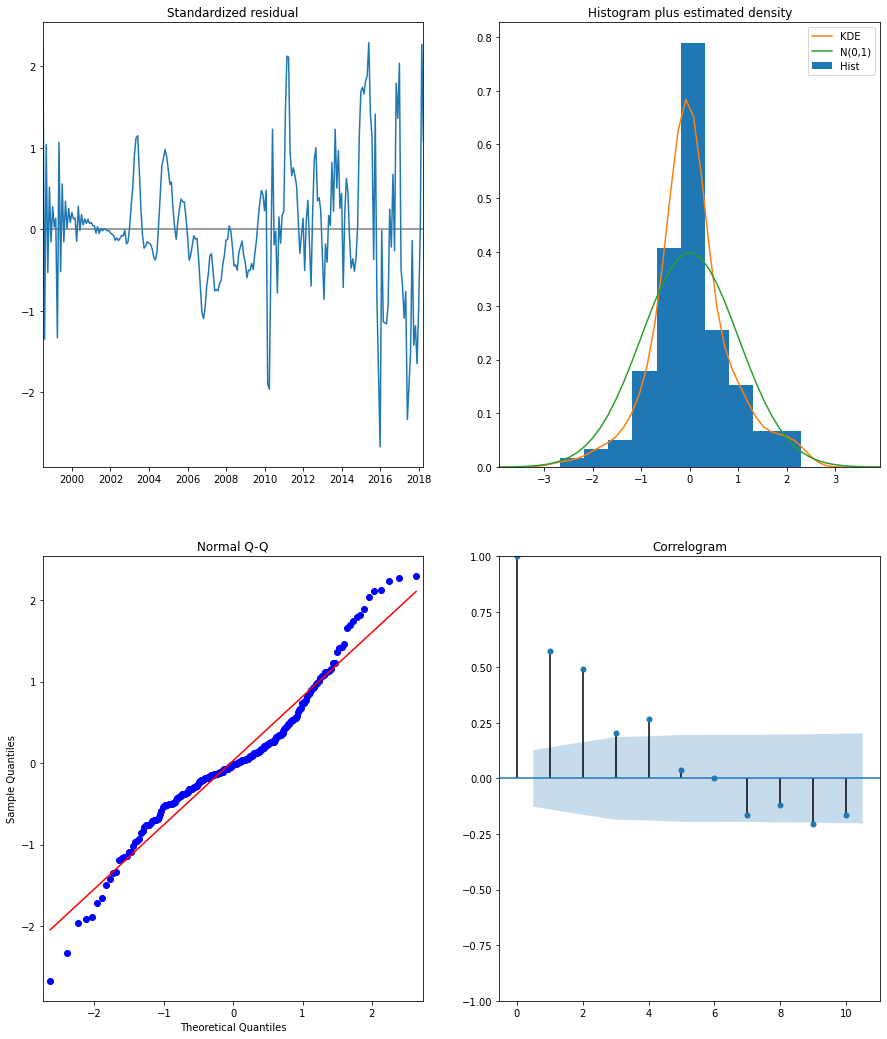

In [ ]:
zip_rois={}
steps = 36

#def zipcode_roi(output_df,):
for zipcode in output_df['zipcode'].unique():
  pdq = output_df.loc[ output_df['zipcode']==zipcode, 'pdq'].iloc[0] 
  seasonal = output_df.loc[ output_df['zipcode']==zipcode, 'seasonal_pdq'].iloc[0] 
  df_ts = zip_df[zipcode]


  output_sarima = fit_ARIMA(df_ts, order=pdq, seasonal_order=seasonal)
  prediction_object = output_sarima.get_forecast(steps=steps, dynamic=True)
  my_output = my_function(prediction_object, zip=zipcode)
  
  roi_dic = {}

  cost = my_output.iloc[0,0]
  current = my_output.iloc[-1,0]
  current_lower = my_output.iloc[-1,1]
  current_upper = my_output.iloc[-1,2]

  my_roi(cost, current)
  roi_dic['roi'] = my_roi(cost, current)
  roi_dic['roi_lower'] = my_roi(cost, current_lower)
  roi_dic['roi_upper'] = my_roi(cost, current_upper)

  zip_rois[zipcode] = pd.Series(roi_dic)
ROI = pd.DataFrame(zip_rois)

In [ ]:
roi_df = ROI.T 
roi_df.reset_index(inplace=True)
roi_df.rename(columns={'index':'zipcode'}, inplace=True)
roi_df.style.background_gradient()

#### **ROI Chart**

In [ ]:
roi_chart_1 = roi_df.sort_values(by=['roi'],ascending=False)
#roi_chart_1 = roi_chart_1.round(3)
roi_chart_1.style.background_gradient()

## **Dynamic Forecasting**
Forecasting begins 4-1-2018

In [ ]:
def forecast_function(output_df, current_zip=None,steps=None):
  
  # roi_t[roi_t[roi_t.name]== current_zip]
  # print('\n')
  zip_params = output_df[output_df['zipcode']==current_zip]
  zip_params.pdq.values[0]
  zip_params.seasonal_pdq.values[0]

  #steps = 36
  output_sar = fit_ARIMA(zip_df[current_zip], order=zip_params.pdq.values[0], seasonal_order=zip_params.seasonal_pdq.values[0])
  prediction = output_sar.get_forecast(steps=steps, dynamic=True)
  prediction.predicted_mean

  # Get confidence intervals of forecasts
  predict_conf = prediction.conf_int()

  return prediction, predict_conf, current_zip


In [ ]:
def forecast_visual(prediction,predict_conf, y, figsize=None):
  """
  prediction-statsmodel object
  predict_conf- pd Dataframe
  """
  print(roi_df[roi_df['zipcode']== current_zip])
  print('\n')
  # Plot future predictions with confidence intervals
  fig,ax = plt.subplots(figsize=figsize)
  ax = y.plot(label='Observed') #(10, 8))
  prediction.predicted_mean.plot(ax=ax, label='Future Forecast')
  ax.fill_between(predict_conf.index,
                  predict_conf.iloc[:, 0],
                  predict_conf.iloc[:, 1], color='k', alpha=0.25)
  
    #I added this and can delete  
    #ax.axvline(prediction.predicted_mean.index[12])

  label_font = {'weight':'bold','size':18}
  ax.set_xlabel('Date',fontdict=label_font)
  ax.set_ylabel('Home Prices',fontdict=label_font)
  ax.set_title(f'Price Forecast for Zipcode: {y.name} /{steps} Months ',fontdict=label_font)

  ax.legend(loc="upper left")

  return ax





### **Zipcode: 11223**
Zipcode 11223 ranks in 1st place for ROI.  The ROI will be 60% on average.<br>
If an investment is made for a return on the lower end the return will be 5.27.<br> 
If a ninvestment is made for a return on the upper end the return will be 86.31.  This will take you into year 2021 and after.<br>
Either way it's a good return on the investment.

In [ ]:
#prediction, predict_conf, current_zip =  forecast_function(output_df, current_zip=11210, steps=36)
#df_test['Btime'].iloc[0]
prediction, predict_conf, current_zip =  forecast_function(output_df, current_zip=roi_chart_1['zipcode'].iloc[0], steps=36)

In [ ]:
test_brk[roi_chart_1['zipcode'].iloc[0]].plot()

In [ ]:
test_brk[roi_chart_1['zipcode'].iloc[0]].describe()

In [ ]:
forecast_visual_zip = forecast_visual(prediction,predict_conf,test_brk[roi_chart_1['zipcode'].iloc[0]], figsize=(12,8))
forecast_visual_zip

### **Zipcode: 11210**

In [ ]:
prediction, predict_conf, current_zip =  forecast_function(output_df, current_zip=roi_chart_1['zipcode'].iloc[1],steps=36)

In [ ]:
test_brk[11233].describe()

In [ ]:
test_brk[roi_chart_1['zipcode'].iloc[1]].plot()

In [ ]:
forecast_visual_zip = forecast_visual(prediction,predict_conf,test_brk[roi_chart_1['zipcode'].iloc[1]], figsize=(12,8))
forecast_visual_zip

### **Zipcode: 11230**

In [ ]:
prediction, predict_conf, current_zip =  forecast_function(output_df, current_zip=roi_chart_1['zipcode'].iloc[2],steps=36)

In [ ]:
test_brk[roi_chart_1['zipcode'].iloc[2]].describe().round(3)

In [ ]:
test_brk[roi_chart_1['zipcode'].iloc[2]].plot()

In [ ]:
forecast_visual_zip = forecast_visual(prediction,predict_conf,test_brk[roi_chart_1['zipcode'].iloc[2]], figsize=(12,8))
forecast_visual_zip

### **Zipcode: 11224**

In [ ]:
prediction, predict_conf, current_zip =  forecast_function(output_df, current_zip=roi_chart_1['zipcode'].iloc[3],steps=36)

In [ ]:
test_brk[11230].describe().round(3)

In [ ]:
test_brk[roi_chart_1['zipcode'].iloc[3]].plot()

In [ ]:
forecast_visual_zip = forecast_visual(prediction,predict_conf,test_brk[roi_chart_1['zipcode'].iloc[3]], figsize=(12,8))
forecast_visual_zip

### **Zipcode: 11233**

In [ ]:
prediction, predict_conf, current_zip =  forecast_function(output_df, current_zip=roi_chart_1['zipcode'].iloc[4],steps=36)

In [ ]:
test_brk[roi_chart_1['zipcode'].iloc[4]].describe().round(3)

In [ ]:
test_brk[roi_chart_1['zipcode'].iloc[4]].plot()

In [ ]:

forecast_visual_zip = forecast_visual(prediction,predict_conf,test_brk[roi_chart_1['zipcode'].iloc[4]], figsize=(12,8))
forecast_visual_zip

## ***Stationarity***

### **Zipcode: 11226**

In [ ]:
zip_df[11226].plot()

In [ ]:
def test_stationarity_1(timeseries, window):
    
    #Defining rolling statistics
    rolmean = timeseries.rolling(window=window).mean()
    rolstd = timeseries.rolling(window=window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries.iloc[window:], color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='upper left')
    plt.title('Rolling Mean & Standard Deviation')
    plt.legend(bbox_to_anchor=(1.05,1),loc='upper left')
    plt.show()
    

In [ ]:
#Not mine

def dickey_fuller_test_ind_zip(zip_code):
    dftest = adfuller(zip_code)

    # Extract and display test results in a user friendly manner
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dftest)

    print ('Results of Dickey-Fuller Test:')

    return dfoutput

In [ ]:
new_dic = {}
for col in zip_df.columns:
  zip_test = dickey_fuller_test_ind_zip(zip_df[col])
  new_dic[col] = zip_test

In [ ]:
new_dic[11226]

In [ ]:

def dickey_fuller_test_zipcodes(df):
    for col in df.columns:
        dftest = adfuller(df[col])
        dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
        for key,value in dftest[4].items():
            dfoutput['Critical Value (%s)'%key] = value
        print ('Results of Dickey-Fuller Test:')
        
        print(dfoutput) 
        #print(dftest)
        print ('\n')         

In [ ]:
dickey_fuller_test_zipcodes(zip_df)

In [ ]:
X_1 = zip_df.copy()

In [ ]:
def stationary_test(df):
    rolling_mean = df.rolling(window=12).mean()
    rolling_std = df.rolling(window=12).std()

    plt.plot(df,color='blue',label='orignal')
    plt.plot(rolling_mean, color='red',label='Rolling Mean')
    plt.plot(rolling_std, color='green',label='Rolling STD')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Rolling Standard Deviation')
    #plt.show()
    result = adfuller(df)
    print('ADF statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{} : {}'.format(key,value))
        
    names = ['Test Statistic','p-value','#Lags Used','# of Observations Used']
    res  = dict(zip(names,result[:4]))
    res['Stationary Results'] = res['p-value']<.05
    
    return pd.DataFrame(res,index=['AD Fuller Results'])    

In [ ]:
stationary_test(zip_df[11226])

###  Zipcode:  11238

In [ ]:
#brooklyn_zips[11226]

In [ ]:
#stationary_test(zip_df[11238])

### Zipcode:  11215

In [ ]:
stationary_test(zip_df[11226])

### Removing Trend
#### Log-Transformation (np.log)

In [ ]:
## Log Transform
ts3 = np.log(zip_df[11226])
#ts3.plot()
stationary_test(ts3)

#### Differencing

In [ ]:
"""
#subtracts the ts 1 step forward from itself. Good way of eliminting trend

#below ts centered around 0
#we achieved stationarity
#eliminating day-to-day patterns
"""
ts0 = zip_df[11226].diff().dropna()
#ts0.plot()

stationary_test(ts0)

#### Subtract Rolling Mean 

In [ ]:
## Subtract Rolling mean
ts2 = (zip_df[11226] - zip_df[11226].rolling(3).mean()).dropna()
#ts2.plot()
stationary_test(ts2)

#### Subtract Exponentially-Weighted Mean 

In [ ]:
## Subtract Exponentially Weight Mean Rolling mean
ts4 = (zip_df[11226] - zip_df[11226].ewm(halflife=7).mean()).dropna()
#ts4.plot()
stationary_test(ts4)

#### Seasonal Decomposition 

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomp = seasonal_decompose(zip_df[11226])#,model='mul')
decomp.plot();

In [ ]:
## Get ADFuller Results for seasonal component
stationary_test(decomp.seasonal)

In [ ]:
## Get ADFuller Results for trend component
stationary_test(decomp.trend.dropna())

In [ ]:
## Get ADFuller Results for resid component
stationary_test(decomp.resid.dropna())

In [ ]:
decomp.resid.dropna()

## **RNN**

In [ ]:
df_rnn = zip_df[[11238]]

In [ ]:
df_rnn.head()

In [ ]:
df_rnn.plot()

In [ ]:
len(df_rnn)

In [ ]:
265-12

In [ ]:
"""
x_train= x_train.reshape(-1, 1)
y_train= y_train.reshape(-1, 1)
x_test = x_test.reshape(-1, 1)
"""
train = df_rnn.iloc[:253]
test = df_rnn.iloc[253:]
#test = test.reshape(1, -1)
#train= train.reshape(-1, 1)

In [ ]:
test

In [ ]:
len(test)

In [ ]:
train.shape

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [ ]:
scaled_train

In [ ]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [ ]:
n_input = 2
n_features = 1 #smaller batch sizes lead to better training

generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [ ]:
scaled_train[:5]

In [ ]:
len(scaled_train)

In [ ]:
"""

253 - n_input(2)

"""
len(generator)

In [ ]:
#create model and fit it to the generator object
from keras.models import Sequential
from keras.layers import Dense  #for final output later
from keras.layers import LSTM #long short term memory

In [ ]:
n_input = 12 #look at full year of data or 12 months before predicting 13th month
n_features = 1 #smaller batch sizes lead to better training
               #how many columns you have. WE have 1 column which is time stamp for y

train_generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [ ]:
model = Sequential()

model.add(LSTM(150, activation='relu', input_shape=(n_input, n_features)))
#need to aggregate all the neurons to sngle prediciton
model.add(Dense(1)) #added single dense neuron which will directly output our prediction
model.compile(optimizer='adam', loss='mse')

In [ ]:
"""
may want to play around w/number of neurons on LSTM layer
"""
model.summary()

In [ ]:
"""
fit tou our training generator
more epochs you use hte longer it's going to take to train
1 epoch is a single entire run through of training data

We get significant reduciton over 1st couple of epochs then around 15 start seeing convergence

"""
model.fit_generator(train_generator, epochs=25)

In [ ]:
model.history.history.keys()

In [ ]:
plt.plot(range(len(model.history.history['loss'])),model.history.history['loss']);

In [ ]:
"""
evalute on the test data
create an evlauation batch
our network trains 1 step ahead

our network is 12 network steps 
    then predict step 13
    
need last 12 points of training data inorder to predict pt. 1 of test data 

these are last 12 points of training set
"""
first_eval_batch = scaled_train[-12:]
first_eval_batch

In [ ]:
"""
it now has 3 brackets at the top
"""
first_eval_batch = first_eval_batch.reshape((1,n_input,n_features))
first_eval_batch

In [ ]:
"""
call model on first_eval_batch
gives array prediciton
means given these 12 points of training data it predicts taht below should be 1st point of test data set
"""
model.predict(first_eval_batch)

In [ ]:
scaled_test

In [ ]:
"""
not just predict 1st point in test set but the entire test set
how to forecast into the future
Forecast using RNN model
"""
#hold predicitons
test_predictions = []
#last n_input points from training set
first_eval_batch = scaled_train[-n_input:] 
#reshape to format of RNN wants, (same format as Timeseriesgenerator 
current_batch = first_eval_batch.reshape((1,n_input,n_features))

#hoe far into the futrue will I forecast: length of test set
for i in range(len(test)):
    #1time step ahead of historical 12 points
    current_pred = model.predict(current_batch)[0] #0 is for formatting 
    test_predictions.append(current_pred)
    
    #update current batch to include prediciton
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [ ]:
test_predictions

In [ ]:
true_predictions = scaler.inverse_transform(test_predictions)
true_predictions

In [ ]:
test['Predictions'] = true_predictions

In [ ]:
test

### **RNN Plot / Sales v Predicted Values**

In [ ]:
"""
sales v predicted values
"""
test.plot(figsize=(12,5));

### **Recommendations**
Below are the Brooklyn zipcodes with the predicted Top 5 ROIs which I would recommend investing in:<br>
11223  (63%)<br>
11210  (59%)<br>
11230  (46%)<br>
11224  (45%)<br>
11233  (42%)<br>